In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import math 
import time
from sklearn.metrics import mean_squared_error

In [3]:
def covariates1():
    x0 = np.ones((1000,))
    x1 = np.random.normal(size = (1000,))
    x2 = np.random.normal(loc = 2, size = (1000,))
    X = np.array([x0, x1, x2]).T
    return X
covariates1()

array([[ 1.        , -0.49541122,  1.7139515 ],
       [ 1.        ,  0.65350021,  2.44645891],
       [ 1.        ,  0.80514247,  1.1098424 ],
       ...,
       [ 1.        ,  2.68850205,  3.20766428],
       [ 1.        , -0.60279542,  1.68901636],
       [ 1.        ,  1.70153794,  1.62619388]])

In [5]:
def covariates2(n):
    x0 = np.ones((n,))
    x1 = np.random.normal(loc = 5, size = (n,))
    x2 = np.random.normal(loc = -3, size = (n,))
    x3 = np.random.normal(loc = 3, size = (n,))
    X = np.array([x0,x1,x2,x3]).T
    return X
covariates2(3000)

array([[ 1.        ,  4.97755561, -0.85883729,  5.48029709],
       [ 1.        ,  5.98848434, -3.56461093,  3.46768462],
       [ 1.        ,  6.07707958, -4.09122626,  2.13257182],
       ...,
       [ 1.        ,  5.63764575, -4.18670228,  4.38535116],
       [ 1.        ,  5.21498056, -2.43418389,  2.44677227],
       [ 1.        ,  4.98644935, -3.21023137,  3.97374323]])

In [6]:
#Metropolis Hastings
#Target = Simulation from Poisson
#Auxiliary MC = Symmetric Random Walk

import random
x0 = 0
x = np.zeros((10000,))
i = 0

while i < 10000:
    x[i] = x0
    x1 = x0 + np.random.choice([-1,1])
    target0 = ss.poisson.pmf(x0, mu = 6)
    target1 = ss.poisson.pmf(x1, mu = 6)
    acc_ratio = target1/target0
    acc_p = min(1, acc_ratio)
    u = np.random.uniform(0,1)
    if u <= acc_p:
        x0 = x1
    i += 1 

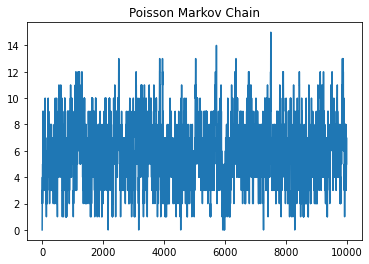

In [158]:
plt.plot(x)
plt.title('Poisson Markov Chain')
plt.show()

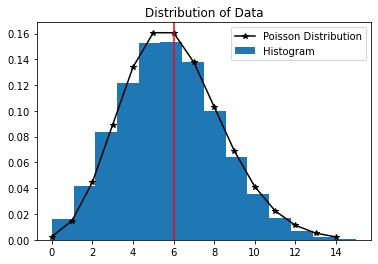

In [160]:
#Distribution of the random variables
plt.hist(x[1000:], bins = 14, density = True, label = 'Histogram')
grid = np.arange(0, 15)
plt.plot(grid, ss.poisson.pmf(grid, mu = 6), marker = '*', color = 'k', label = 'Poisson Distribution')
plt.axvline(6, color = 'r')
plt.title('Distribution of Data')
plt.legend()
plt.show()

In [7]:
def MCMC(X, b0, iterations, beta0, v0):    
    start = time.time()
    acc = 0
    acc_rate = np.zeros((iterations,))
    b = np.zeros((iterations, len(b0)))
    i = 0
    while i < iterations:
        #Fisher Information
        b[i, :] = b0
        eta0 = np.dot(X,b0)
        u0 = ss.norm.cdf(eta0)
        
        u0[u0 < 0.0001] = 0.0001
        u0[u0 > 0.9999] = 0.9999
        
        #print(u0)
        varY0 = u0*(1-u0)
        w0 = (1/varY0)*(ss.norm.pdf(eta0)**2)
        W0 = np.diag(w0)
        fish = np.dot(np.dot(X.T, W0), X)
        cov = np.linalg.inv(fish)
        
        #Proposal
        b1 = np.random.multivariate_normal(b0, cov)
        eta1 = np.dot(X, b1)
        u1 = ss.norm.cdf(eta1)

        #Likelihoods
        like0 = math.prod(((u0)**Y)*((1-u0)**(1-Y)))
        like1 = math.prod(((u1)**Y)*((1-u1)**(1-Y)))

        #Priors
        prior0 = ss.multivariate_normal.pdf(b0, mean = beta0, cov = v0)
        prior1 = ss.multivariate_normal.pdf(b1, mean = beta0, cov = v0)

        #Acceptance Ratio
        acc_ratio = (like1*prior1)/(like0*prior0)
        u = np.random.uniform(0,1)
        acc_p = min(1, acc_ratio)
        if u <= acc_p:
            b0 = b1
            acc += 1
        acc_rate[i] = acc/(i+1)
        i += 1
    end = time.time()
    print(f'Time: {end-start} seconds')
    return b, acc_rate

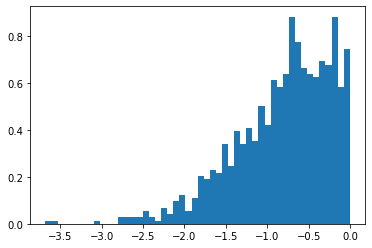

In [8]:
#Simulated Truncated Normal
y = np.zeros((1000,))
for i in range(1000):
    u = random.uniform(0,1)
    p = u*ss.norm.cdf(0)
    q = 0 + ss.norm.ppf(p)
    y[i] = q
plt.hist(y, bins = 50, density = True)
plt.show()

In [9]:
def uninformed_gibbs(X, b0, iterations):
    start = time.time()
    b = np.zeros((iterations, len(b0)))
    j = 0
    while j < iterations:
        b[j, :] = b0
        eta0 = np.dot(X,b0)
        z0 = np.zeros((X.shape[0],))
        mask0 = 1*(Y == 0)
        mask1 = 1*(Y == 1)
        u = np.random.uniform(size = X.shape[0])
        p0 = u*ss.norm.cdf(0, eta0)
        p0 = p0*mask0
        p1 = ss.norm.cdf(0, loc= eta0) + u*(1 - ss.norm.cdf(0, loc = eta0))
        p1 = p1*mask1

        #p0[p0 < 0.00001] = 0.00001
        #p0[p0 > 0.99999] = 0.99999
        #p1[p1 < 0.00001] = 0.00001
        #p1[p1 > 0.99999] = 0.99999
   
        P = np.zeros((X.shape[0],)) + p0 + p1
        z0 = eta0 + ss.norm.ppf(P)
        mean_posterior = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, z0))
        variance_posterior = np.linalg.inv(np.dot(X.T,X))
        b1 = np.random.multivariate_normal(mean_posterior, variance_posterior)
        b0 = b1
        j += 1

    end = time.time()
    print(f'Time: {end-start} seconds')
    return b

In [164]:
def informed_gibbs(X, b0, iterations, beta0, v0):
    start = time.time()
    b = np.zeros((iterations, len(b0)))
    j = 0
    while j < iterations:
        b[j, :] = b0
        eta0 = np.dot(X,b0)
        z0 = np.zeros((X.shape[0],))
        mask0 = 1*(Y == 0)
        mask1 = 1*(Y == 1)
        u = np.random.uniform(size = X.shape[0])
        p0 = u*ss.norm.cdf(0, eta0)
        p0 = p0*mask0
        p1 = ss.norm.cdf(0, loc= eta0) + u*(1 - ss.norm.cdf(0, loc = eta0))
        p1 = p1*mask1
   
        #p0[p0 < 0.00001] = 0.00001
        #p0[p0 > 0.99999] = 0.99999
        #p1[p1 < 0.00001] = 0.00001
        #p1[p1 > 0.99999] = 0.99999
  
        P = np.zeros((X.shape[0],)) + p0 + p1
        z0 = eta0 + ss.norm.ppf(P)
        
        mean1 = np.linalg.inv(np.linalg.inv(v0) + np.dot(X.T,X))
        mean2 = np.dot(np.linalg.inv(v0), beta0) + np.dot(X.T, z0)
        mean_posterior = np.dot(mean1, mean2)
        variance_posterior = np.linalg.inv(np.linalg.inv(v0) + np.dot(X.T,X))
        b1 = np.random.multivariate_normal(mean_posterior, variance_posterior)
        b0 = b1
        j += 1

    end = time.time()
    print(f'Time: {end-start} seconds')
    return b

# Simulation 1

In [10]:
#Simulation 1
#Distribution of OLS estimators
beta0 = np.zeros((10000,))
beta1 = np.zeros((10000,))
beta2 = np.zeros((10000,))
for i in range(10000):
    X = covariates1()
    beta = np.array([2,1,-1])
    latent = np.dot(X, beta) + np.random.normal(size = (1000,))
    regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))
    beta0[i] = regb[0]
    beta1[i] = regb[1]
    beta2[i] = regb[2]

print([np.mean(beta0), np.mean(beta1), np.mean(beta2)])
print(regb)

[1.9992359508161563, 0.9996735683515723, -0.9997554269217169]
[ 1.98574815  1.02513647 -0.99698746]


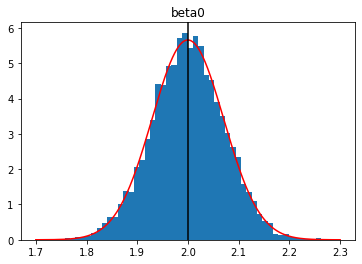

Standard Deviation = 0.07048322382231631


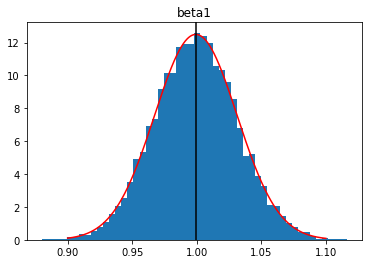

Standard Deviation = 0.031924424686935314


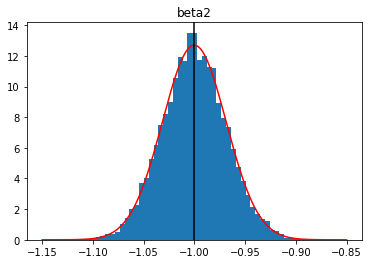

Standard Deviation = 0.031419644461710826


In [342]:
#plt.subplot(311)
grid0 = np.linspace(1.7, 2.3, 1000)
plt.plot(grid0, ss.norm.pdf(grid0, np.mean(beta0), scale = beta0.std()), color = 'r')
plt.hist(beta0, bins = 50, density = True)
plt.axvline(np.mean(beta0), color = 'k')
plt.title('beta0')
plt.show()
print(f'Standard Deviation = {beta0.std()}')

#plt.subplot(312)
grid1 = np.linspace(0.9, 1.1, 1000)
plt.plot(grid1, ss.norm.pdf(grid1, np.mean(beta1), scale = beta1.std()), color = 'r')
plt.hist(beta1, bins = 50, density = True)
plt.axvline(np.mean(beta1), color = 'k')
plt.title('beta1')
plt.show()
print(f'Standard Deviation = {beta1.std()}')

#plt.subplot(313)
grid2 = np.linspace(-1.15, -0.85, 1000)
plt.plot(grid2, ss.norm.pdf(grid2, np.mean(beta2), scale = beta2.std()), color = 'r')
plt.hist(beta2, bins = 50, density = True)
plt.axvline(np.mean(beta2), color = 'k')
plt.title('beta2')
plt.show()
print(f'Standard Deviation = {beta2.std()}')

In [11]:
#Target Distribution Analysis (Referred to Simulation 1)
import pandas as pd
mean_target = np.array([np.mean(beta0), np.mean(beta1), np.mean(beta2)])
beta_all = np.array([beta0, beta1, beta2]).T
cov_target = pd.DataFrame(beta_all).cov()
cov_target = np.array(cov_target)
cov_target
print(f'The mean of the target is \n{mean_target}')
print(f'The variance-covariance matrix of the target is \n{cov_target}')

The mean of the target is 
[ 1.99923595  0.99967357 -0.99975543]
The variance-covariance matrix of the target is 
[[ 5.01638285e-03 -1.37901113e-05 -2.00366813e-03]
 [-1.37901113e-05  1.00897682e-03  5.21929700e-06]
 [-2.00366813e-03  5.21929700e-06  1.00093780e-03]]


In [344]:
#Simulation 1: MCMC 1
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

beta0 = np.zeros((3,))
v0 = np.array([[1,0,0], [0,1,0], [0,0,1]])
b0 = np.array([1.5, 0.5, -0.5])
iterations = 3000
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

Time: 47.905420780181885 seconds


The MSE is 0.00617740095585747


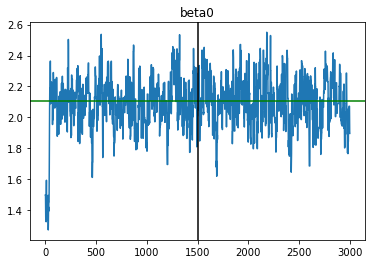

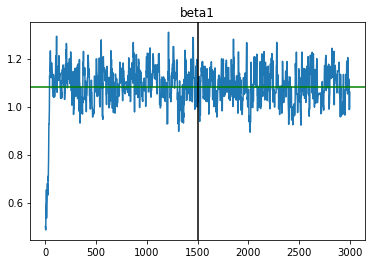

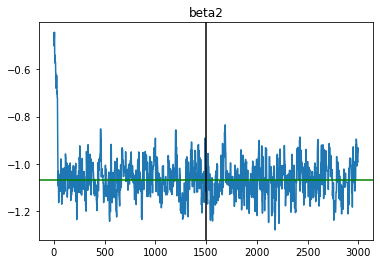

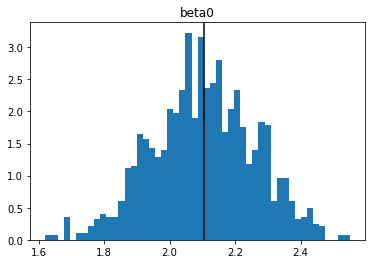

Beta0 Standard Deviation = 0.15668209609652772
Beta0 Mean = 2.091830195700063


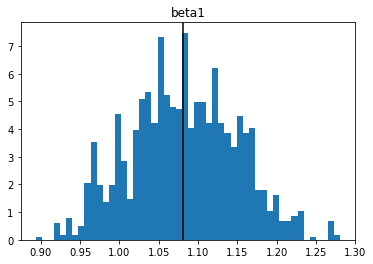

Beta1 Standard Deviation = 0.06752490854340534
Beta1 Mean = 1.0792012980943682


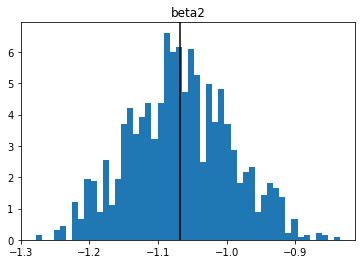

Beta2 Standard Deviation = 0.07365866768229501
Beta2 Mean = -1.0618592952225254


In [347]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.axhline(b[1500:,i].mean(), color = 'g')
    plt.title(f'beta{i}')
    plt.axvline(1500, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[1500:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1500:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[1500:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

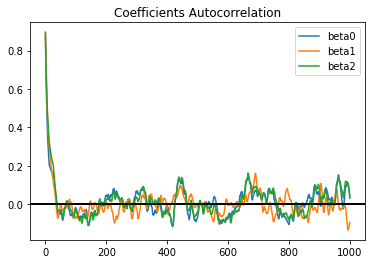

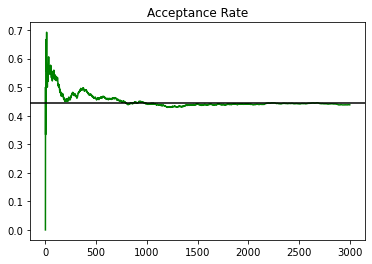

In [348]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(2999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(2999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(2999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc[::-500].mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [258]:
#Simulation 1: MCMC 2
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

beta0 = np.zeros((3,))
v0 = np.array([[1,0,0], [0,1,0], [0,0,1]])

b0 = np.array([1,1,1])
iterations = 5000
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)
<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: divide by zero encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 78.70290970802307 seconds


The MSE is 0.0021164439025294053


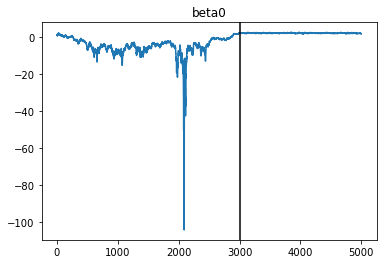

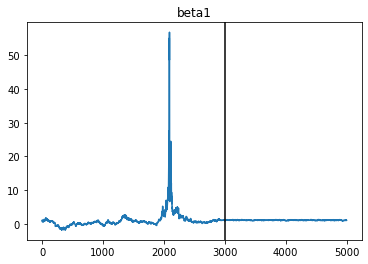

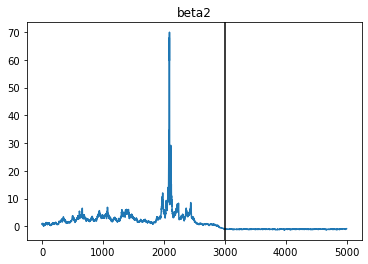

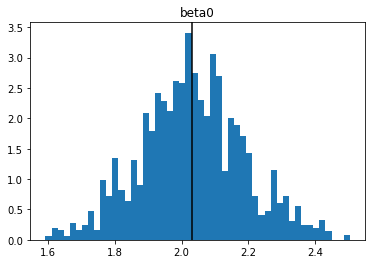

Beta0 Standard Deviation = 0.15479851961799884
Beta0 Mean = 2.0320639235401563


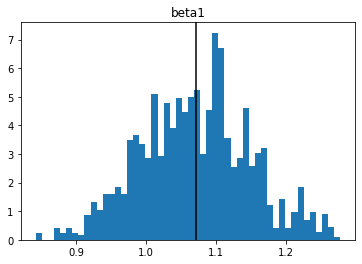

Beta1 Standard Deviation = 0.07819618381812934
Beta1 Mean = 1.0708323507783097


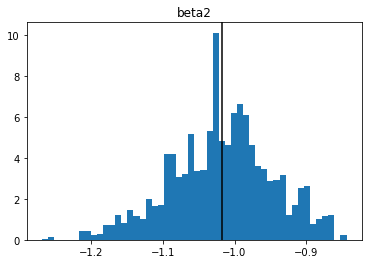

Beta2 Standard Deviation = 0.07133803565175814
Beta2 Mean = -1.0174360143960055


In [264]:
MSE = mean_squared_error(beta, np.array([b[3000:,0].mean(), b[3000:,1].mean(),b[3000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(3000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[3000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[3000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[3000:, i].std()}')
    print(f'Beta{i} Mean = {b[3000:, i].mean()}')

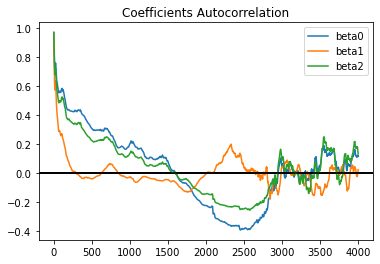

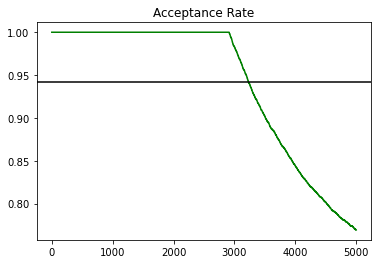

In [266]:
#Autocorrelation Analysis
corr0 = np.zeros((4000,))
for i in range(4000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((4000,))
for i in range(4000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((4000,))
for i in range(4000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [267]:
#Simulation 1: MCMC 3
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

beta0 = np.zeros((3,))
v0 = np.identity(3)

b0 = np.array([5,5,5])
iterations = 5000
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)
<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: divide by zero encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 76.9892635345459 seconds


The MSE is 0.020557377916689254


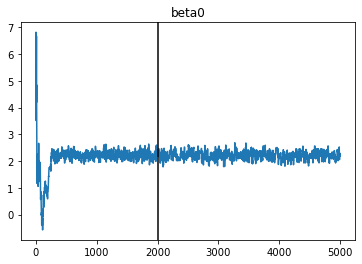

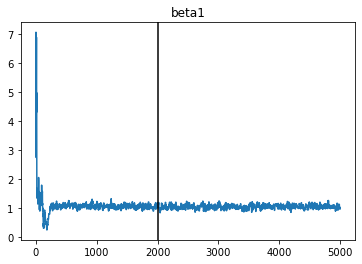

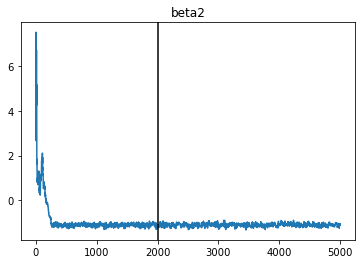

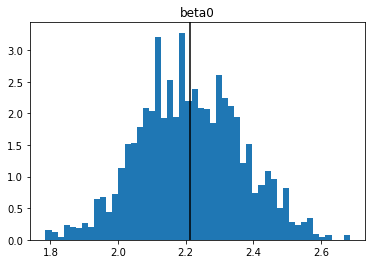

Beta0 Standard Deviation = 0.15176842728846768
Beta0 Mean = 2.21336770154741


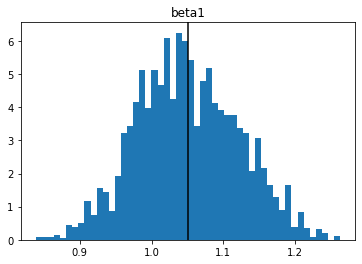

Beta1 Standard Deviation = 0.07095363840567616
Beta1 Mean = 1.0508763139566708


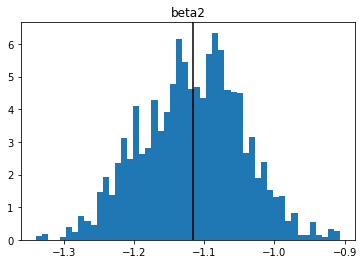

Beta2 Standard Deviation = 0.07189859531759614
Beta2 Mean = -1.1164386463534572


In [268]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1500:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

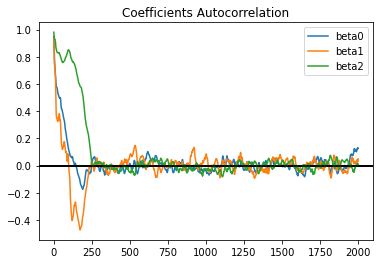

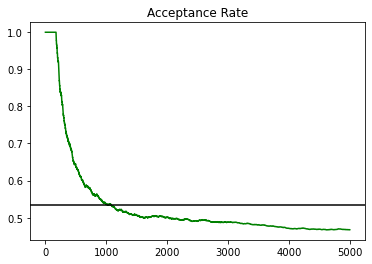

In [269]:
#Autocorrelation Analysis
corr0 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [290]:
#Simulation 1: MCMC 4
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

beta0 = mean_target
v0 = cov_target

b0 = np.array([5,5,5])
iterations = 5000
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)
<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: divide by zero encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 81.47743844985962 seconds


The MSE is 0.0006342092989605569


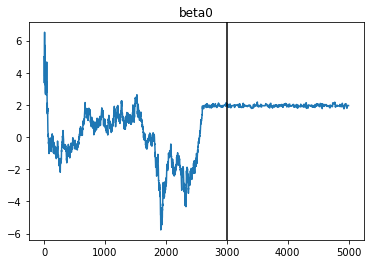

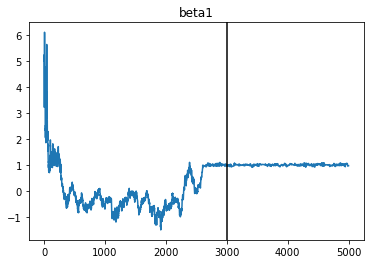

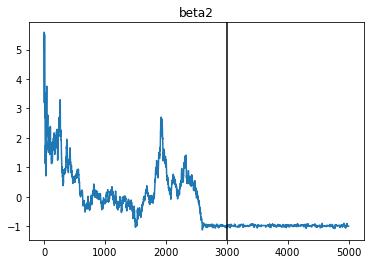

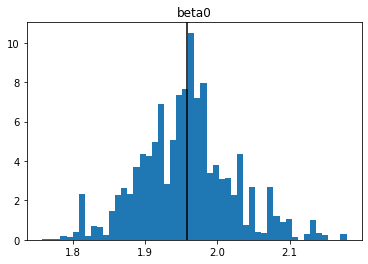

Beta0 Standard Deviation = 0.06512673021865309
Beta0 Mean = 1.957563905866674


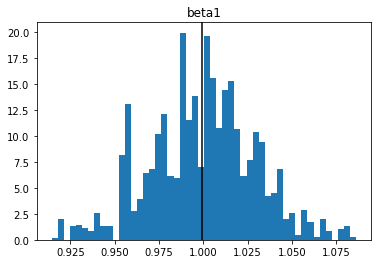

Beta1 Standard Deviation = 0.029899273177338245
Beta1 Mean = 0.9994735509563032


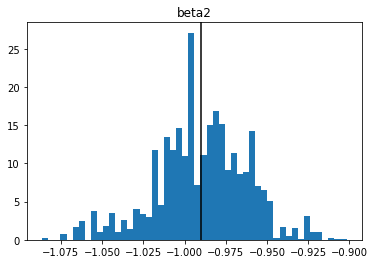

Beta2 Standard Deviation = 0.028436878337207767
Beta2 Mean = -0.9899238567401232


In [291]:
MSE = mean_squared_error(beta, np.array([b[3000:,0].mean(), b[3000:,1].mean(),b[3000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(3000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[3000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[3000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[3000:, i].std()}')
    print(f'Beta{i} Mean = {b[3000:, i].mean()}')

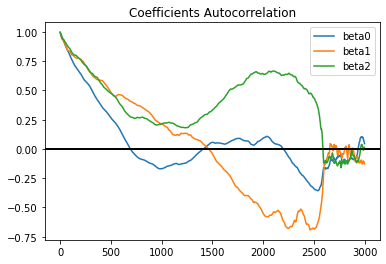

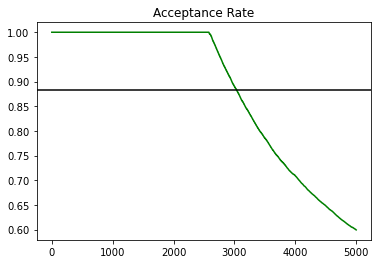

In [293]:
#Autocorrelation Analysis
corr0 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [484]:
#Simulation 1: MCMC 5
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

beta0 = np.zeros((3,))
v0 = np.identity(3)

b0 = beta*(-5)
iterations = 5000
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)
<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: divide by zero encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 70.49837136268616 seconds


The MSE is 0.0008367917916453612


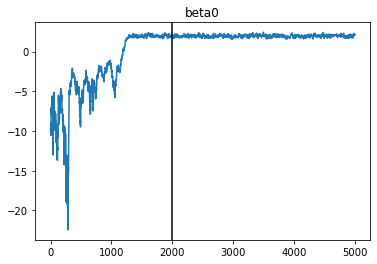

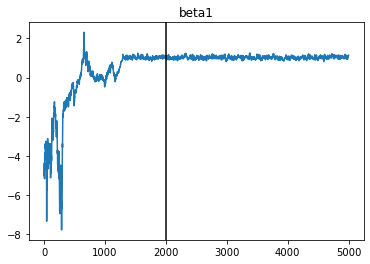

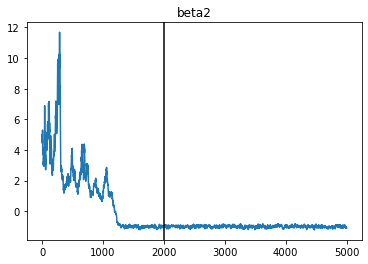

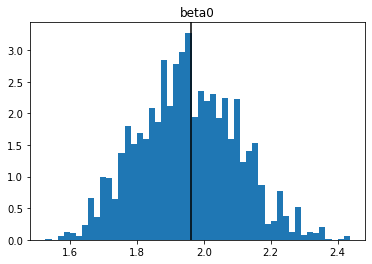

Beta0 Standard Deviation = 0.1473224148004544
Beta0 Mean = 1.9526414837260377


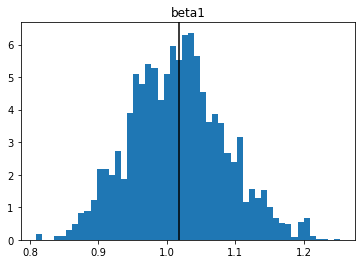

Beta1 Standard Deviation = 0.06961847949927863
Beta1 Mean = 1.0162236379269332


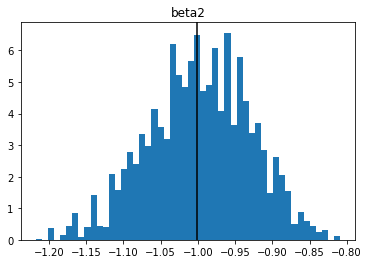

Beta2 Standard Deviation = 0.06890090588528201
Beta2 Mean = -0.9979167612521097


In [485]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[3000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

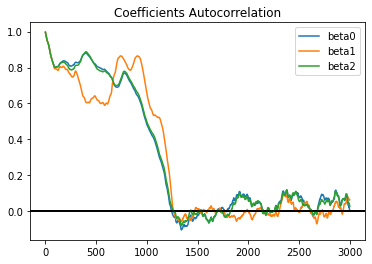

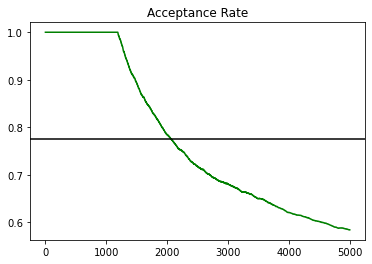

In [486]:
#Autocorrelation Analysis
corr0 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [12]:
#MCMC with Target Distribution as Prior
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

beta0 = mean_target
v0 = np.identity(3)

b0 = np.array([0,0,0])
iterations = 5000
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

Time: 26.643266677856445 seconds


The MSE is 0.0013004101905600737


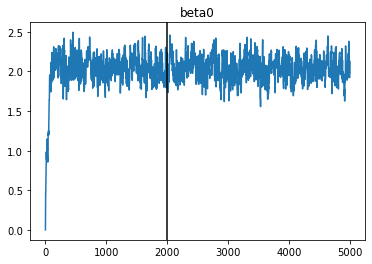

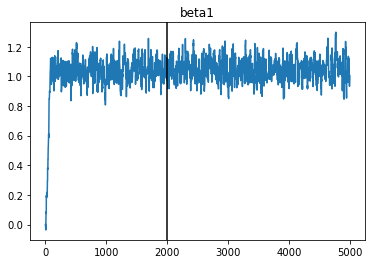

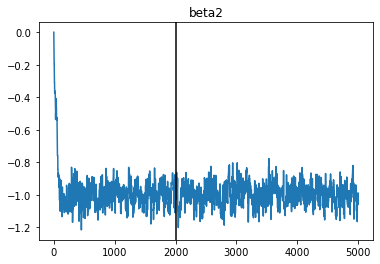

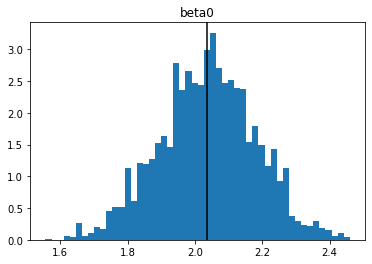

Beta0 Standard Deviation = 0.1424878821079385
Beta0 Mean = 2.03742636421776


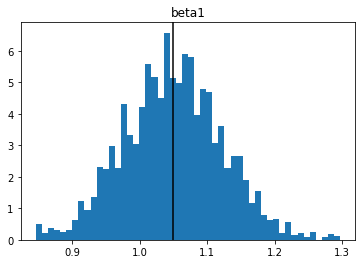

Beta1 Standard Deviation = 0.07301679106123117
Beta1 Mean = 1.0497749967919212


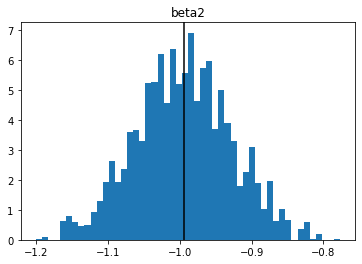

Beta2 Standard Deviation = 0.06725091647173284
Beta2 Mean = -0.995209642238409


In [13]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1500:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

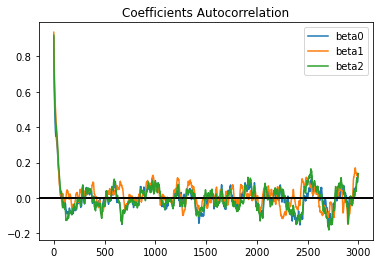

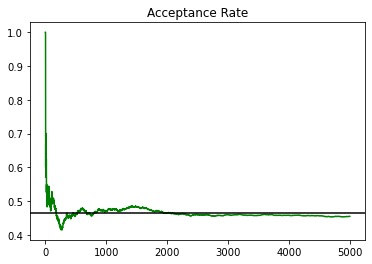

In [14]:
#Autocorrelation Analysis
corr0 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [294]:
#MCMC with Target Posterior Distribution
import pandas as pd
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

start = time.time()
b0 = np.array([3,2,2])
b = np.zeros((5000,3))
i = 0
while i < 5000:
    #Fisher Information
    b[i, :] = b0
    eta0 = np.dot(X,b0)
    u0 = ss.norm.cdf(eta0)
    
    u0[u0 > 0.9999] = 0.9999
    u0[u0 < 0.0001]= 0.0001
    
    varY0 = u0*(1-u0)
    w0 = (1/varY0)*(ss.norm.pdf(eta0)**2)
    W0 = np.diag(w0)
    fish = np.dot(np.dot(X.T, W0), X)
    cov = np.linalg.inv(fish)
 
    #Proposal
    b1 = np.random.multivariate_normal(b0, cov)
      
    #Targets
    target0 = ss.multivariate_normal.pdf(b0, mean_target, cov_target, allow_singular = True)
    target1 = ss.multivariate_normal.pdf(b1, mean_target, cov_target, allow_singular = True)
    
    #Acceptance Ratio
    acc_ratio = target1/target0
    u = np.random.uniform(0,1)
    acc_p = min(1, acc_ratio)
    if u <= acc_p:
        b0 = b1
    i += 1

end = time.time()
print(f'Time: {end-start} seconds')

<ipython-input-294-6417302d5948>:36: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = target1/target0
<ipython-input-294-6417302d5948>:36: RuntimeWarning: divide by zero encountered in double_scalars
  acc_ratio = target1/target0


Time: 77.35112881660461 seconds


The MSE is 6.53791424363712e-06


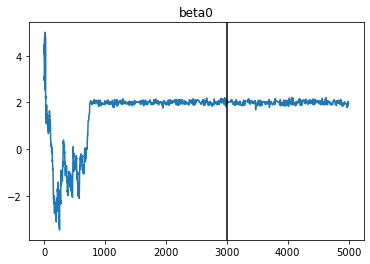

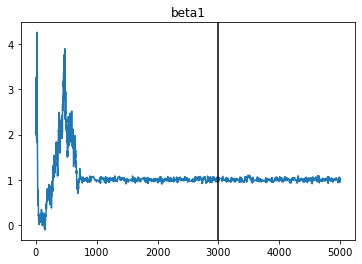

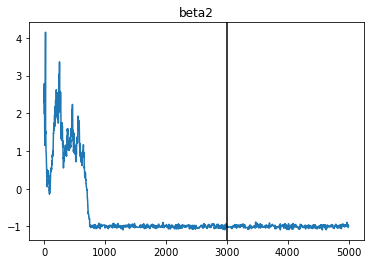

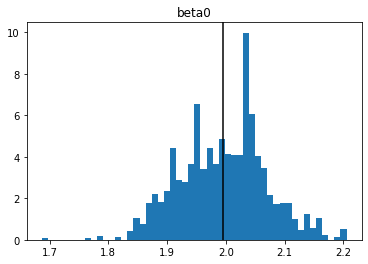

Beta0 Standard Deviation = 0.07431524587729146
Beta0 Mean = 1.99592561248965


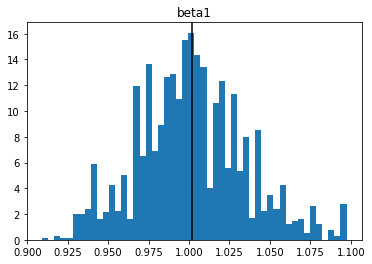

Beta1 Standard Deviation = 0.03315835136655795
Beta1 Mean = 1.0017281570911798


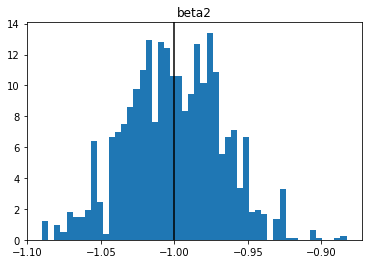

Beta2 Standard Deviation = 0.03256263920605754
Beta2 Mean = -1.0001630405306075


In [295]:
MSE = mean_squared_error(beta, np.array([b[3000:,0].mean(), b[3000:,1].mean(),b[3000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(3000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[3000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[3000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[3000:, i].std()}')
    print(f'Beta{i} Mean = {b[3000:, i].mean()}')

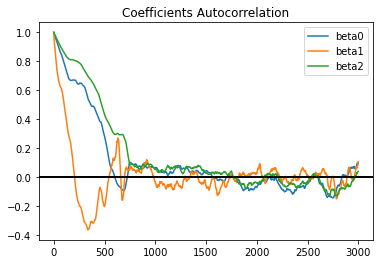

In [296]:
#Autocorrelation Analysis
corr0 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [278]:
#Simulation 1: Uninformed Gibbs 1
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([1.5, 0.5, -0.5])
iterations = 5000

b = uninformed_gibbs(X, b0, iterations)

Time: 12.480709552764893 seconds


The MSE is 0.0032438294392856844


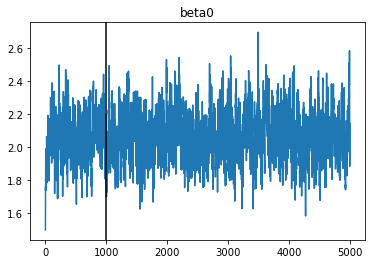

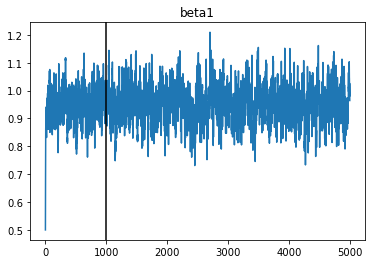

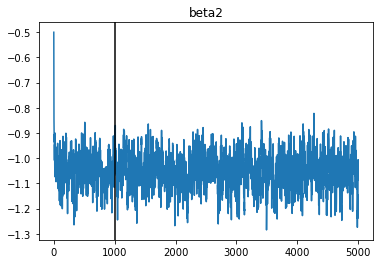

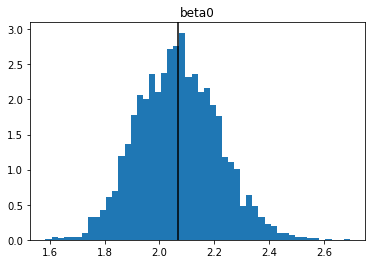

Beta0 Standard Deviation = 0.1478573255774718
Beta0 Mean = 2.0690753165666407


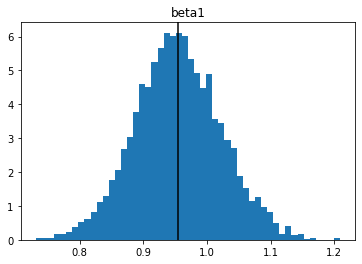

Beta1 Standard Deviation = 0.06821574803002847
Beta1 Mean = 0.9538875863325201


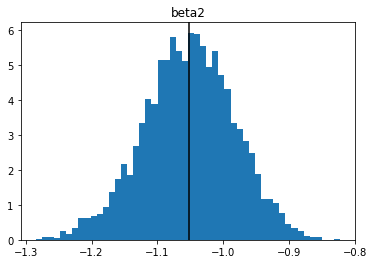

Beta2 Standard Deviation = 0.06970833966294367
Beta2 Mean = -1.0532328307046943


In [279]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

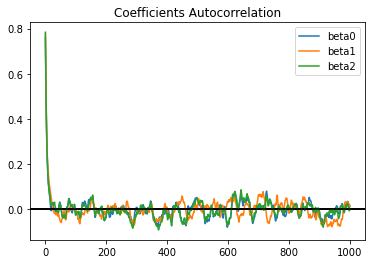

In [280]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [281]:
#Simulation 1: Uninformed Gibbs 2
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([0, 0, 0])
iterations = 5000

b = uninformed_gibbs(X, b0, iterations)

Time: 11.6099271774292 seconds


The MSE is 0.005436308404596187


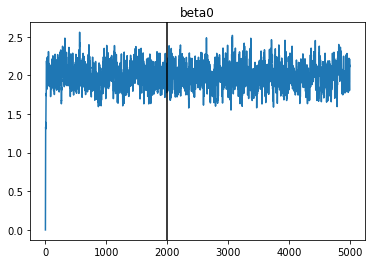

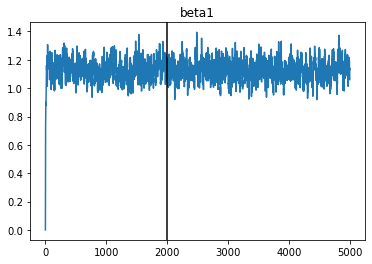

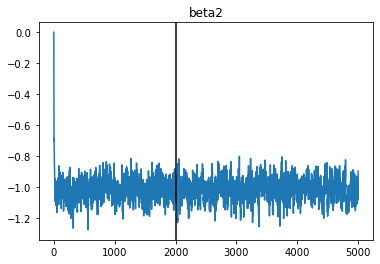

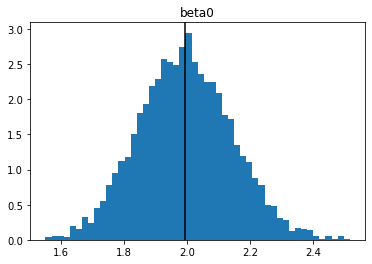

Beta0 Standard Deviation = 0.14781396160771312
Beta0 Mean = 1.9958736006907338


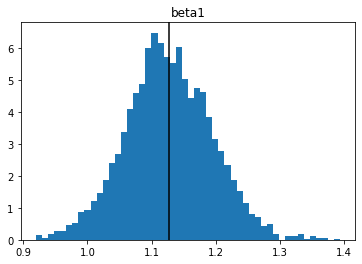

Beta1 Standard Deviation = 0.06740278914351881
Beta1 Mean = 1.126778914144865


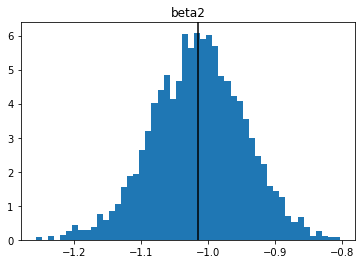

Beta2 Standard Deviation = 0.06881516841675116
Beta2 Mean = -1.0147988165330206


In [282]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

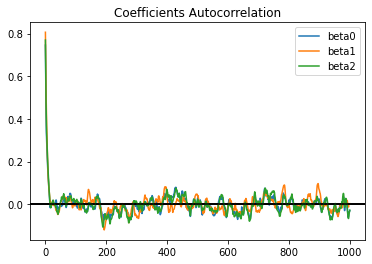

In [283]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [299]:
#Simulation 1: Uninformed Gibbs 3
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([5,5,5])
iterations = 5000

b = uninformed_gibbs(X, b0, iterations) 

Time: 10.199643611907959 seconds


The MSE is 0.01061633723578386


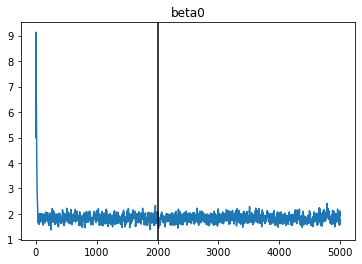

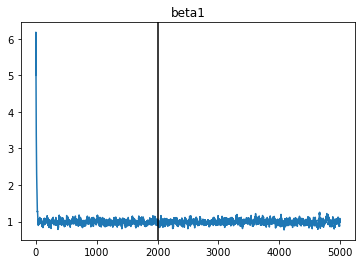

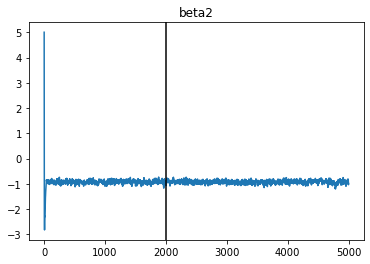

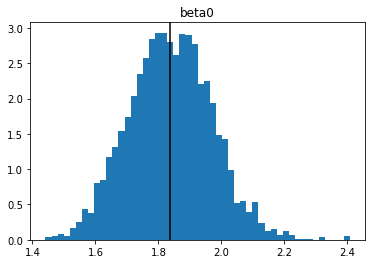

Beta0 Standard Deviation = 0.13211168639838528
Beta0 Mean = 1.8381507770173788


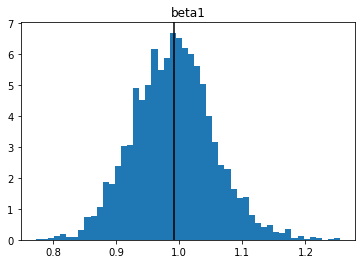

Beta1 Standard Deviation = 0.06409436908107474
Beta1 Mean = 0.9910742597026077


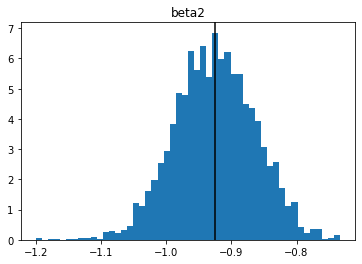

Beta2 Standard Deviation = 0.062204778307586875
Beta2 Mean = -0.9253396230426282


In [300]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

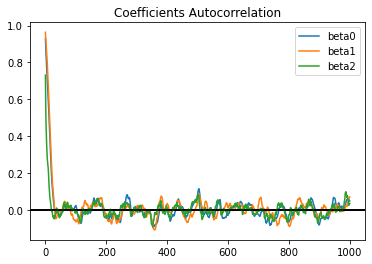

In [301]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [499]:
#Simulation 1: Uninformed Gibbs 3
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = beta*(-5)
iterations = 5000

b = uninformed_gibbs(X, b0, iterations)

#Failed Convergence

Time: 6.930036783218384 seconds


The MSE is 2.766535143020073


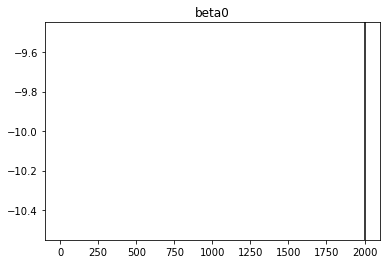

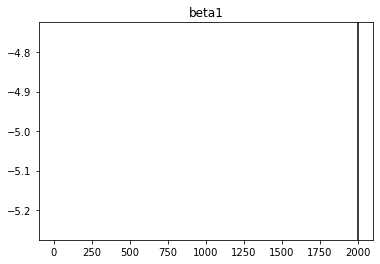

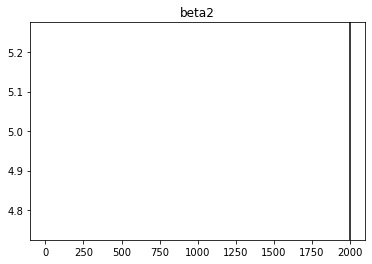

C:\Users\jing\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\jing\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

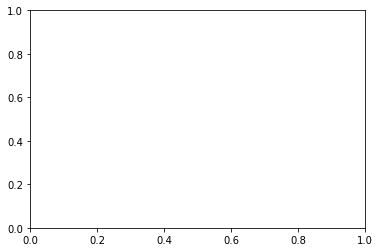

In [501]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

In [502]:
#Simulation 1: Informed Gibbs 1
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([1.5, 0.5, -0.5])
iterations = 5000
#Standard Multivariate Normal
beta0 = np.zeros((3,))
v0 = np.array([[1,0,0], [0,1,0], [0,0,1]])

b = informed_gibbs(X, b0, iterations, beta0, v0)

Time: 10.999717950820923 seconds


The MSE is 0.0007612808160520314


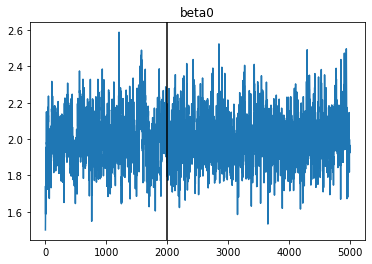

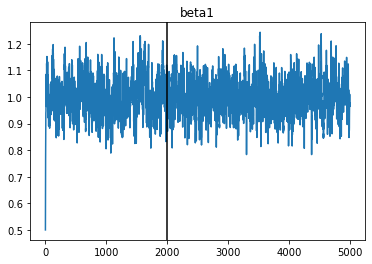

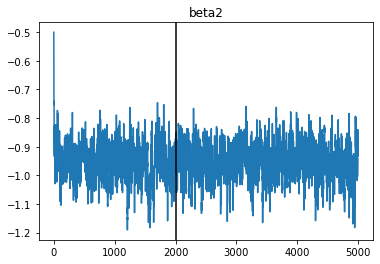

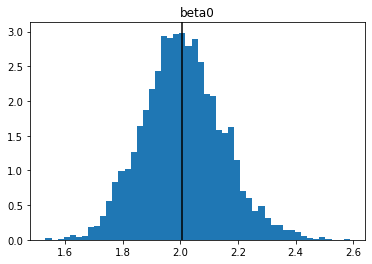

Beta0 Standard Deviation = 0.13550752368615726
Beta0 Mean = 2.0076705019838785


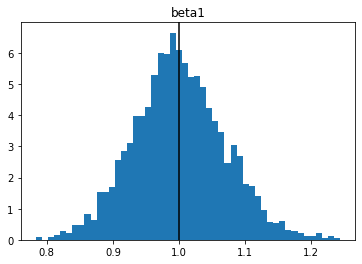

Beta1 Standard Deviation = 0.06640292879328631
Beta1 Mean = 0.9996186974521049


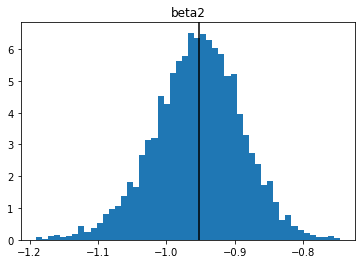

Beta2 Standard Deviation = 0.061115524697060164
Beta2 Mean = -0.9528315735280646


In [503]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(3):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

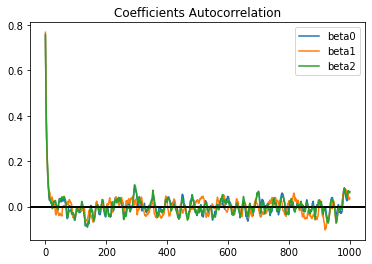

In [504]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [305]:
#Simulation 1: Informed Gibbs 2
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([5,5,5])
iterations = 5000
#Standard Normal Distribution
beta0 = np.zeros((3,))
v0 = np.identity(3)
b = informed_gibbs(X, b0, iterations, beta0, v0) 

Time: 18.01759171485901 seconds


The MSE is 0.004762889287280429


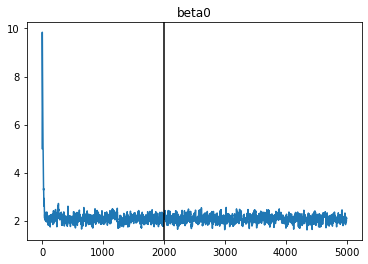

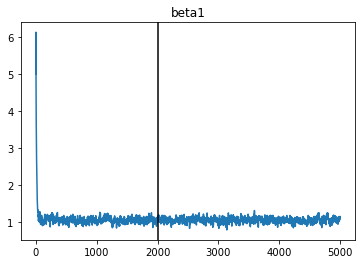

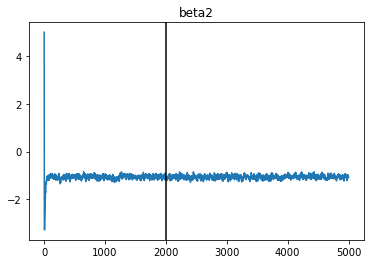

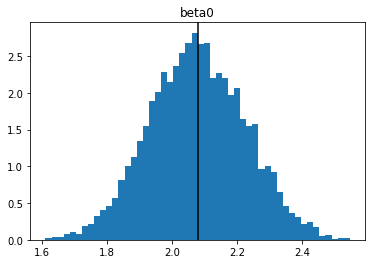

Beta0 Standard Deviation = 0.14813696067692494
Beta0 Mean = 2.07946634633237


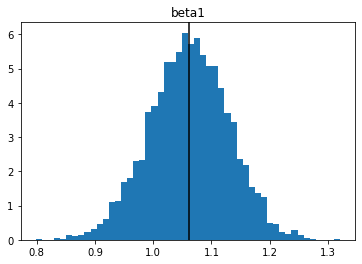

Beta1 Standard Deviation = 0.06731870126405118
Beta1 Mean = 1.0618261305820889


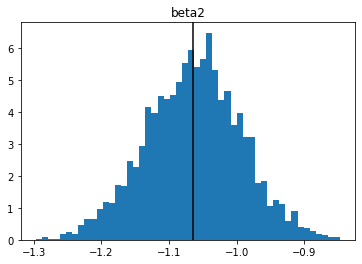

Beta2 Standard Deviation = 0.07036450549019892
Beta2 Mean = -1.0644305613794542


In [306]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(3):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

In [311]:
#Simulation 1: Informed Gibbs 3
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([5,5,5])
iterations = 5000
#Target Distribution
beta0 = mean_target
v0 = cov_target
b = informed_gibbs(X, b0, iterations, beta0, v0) 

Time: 11.061479568481445 seconds


The MSE is 5.5837624215778575e-05


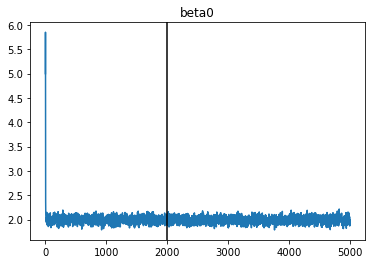

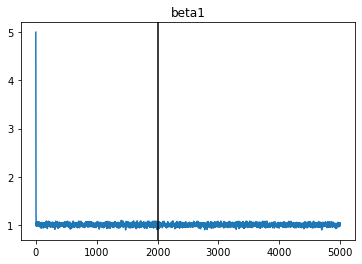

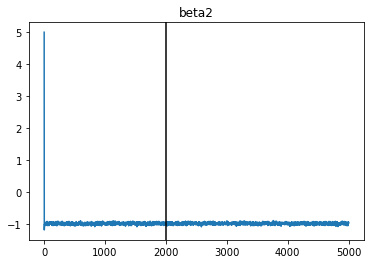

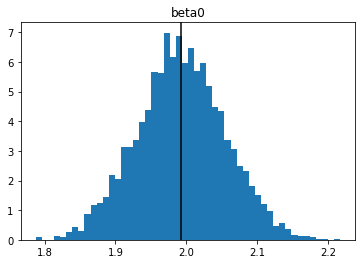

Beta0 Standard Deviation = 0.06187632351163574
Beta0 Mean = 1.9927633663258324


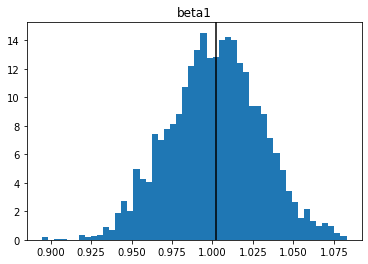

Beta1 Standard Deviation = 0.028262500847828234
Beta1 Mean = 1.001530605833605


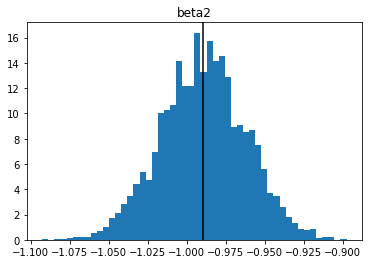

Beta2 Standard Deviation = 0.027293133415852714
Beta2 Mean = -0.9893792066447288


In [312]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean()]))
print(f'The MSE is {MSE}')

for i in range(3):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(3):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

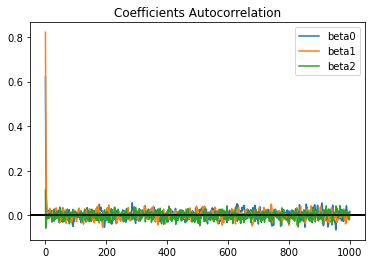

In [314]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')
plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

# Simulation 2

In [349]:
#Simulation 2
#Distribution of OLS estimators
beta0 = np.zeros((10000,))
beta1 = np.zeros((10000,))
beta2 = np.zeros((10000,))
beta3 = np.zeros((10000,))
for i in range(10000):
    X = covariates2(1000)
    beta = np.array([-1,2,3,0.5])
    latent = np.dot(X, beta) + np.random.normal(size = (1000,))
    regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))
    beta0[i] = regb[0]
    beta1[i] = regb[1]
    beta2[i] = regb[2]
    beta3[i] = regb[3]

print([np.mean(beta0), np.mean(beta1), np.mean(beta2), np.mean(beta3)])
print(regb)

[-1.001434014179049, 2.000278825326762, 2.9998057270089973, 0.49983782363238316]
[-0.97810922  2.01435404  2.96141626  0.43941665]


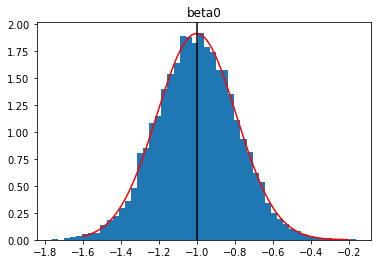

Standard Deviation = 0.2086662906354002


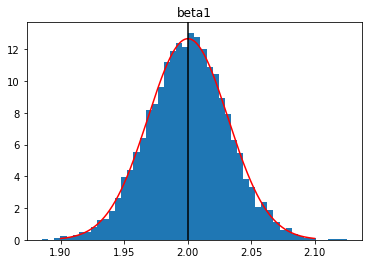

Standard Deviation = 0.03149851887853212


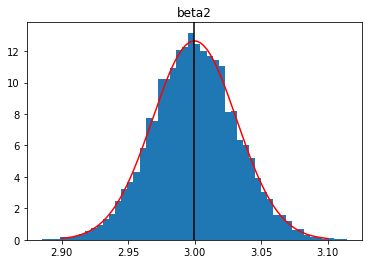

Standard Deviation = 0.03154297445583276


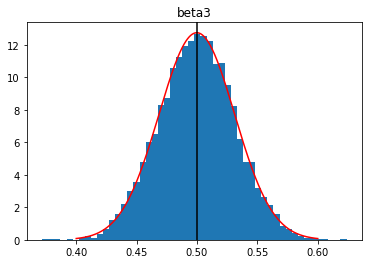

Standard Deviation = 0.031298942049560095


In [350]:
#plt.subplot(311)
grid0 = np.linspace(-1.6, -0.2, 1000)
plt.plot(grid0, ss.norm.pdf(grid0, np.mean(beta0), scale = beta0.std()), color = 'r')
plt.hist(beta0, bins = 50, density = True)
plt.axvline(np.mean(beta0), color = 'k')
plt.title('beta0')
plt.show()
print(f'Standard Deviation = {beta0.std()}')

#plt.subplot(312)
grid1 = np.linspace(1.9, 2.1, 1000)
plt.plot(grid1, ss.norm.pdf(grid1, np.mean(beta1), scale = beta1.std()), color = 'r')
plt.hist(beta1, bins = 50, density = True)
plt.axvline(np.mean(beta1), color = 'k')
plt.title('beta1')
plt.show()
print(f'Standard Deviation = {beta1.std()}')

#plt.subplot(313)
grid2 = np.linspace(2.9, 3.1, 1000)
plt.plot(grid2, ss.norm.pdf(grid2, np.mean(beta2), scale = beta2.std()), color = 'r')
plt.hist(beta2, bins = 50, density = True)
plt.axvline(np.mean(beta2), color = 'k')
plt.title('beta2')
plt.show()
print(f'Standard Deviation = {beta2.std()}')

grid3 = np.linspace(0.4, 0.6, 1000)
plt.plot(grid3, ss.norm.pdf(grid3, np.mean(beta3), scale = beta3.std()), color = 'r')
plt.hist(beta3, bins = 50, density = True)
plt.axvline(np.mean(beta3), color = 'k')
plt.title('beta3')
plt.show()
print(f'Standard Deviation = {beta3.std()}')

In [351]:
#Target Distribution Analysis (Referred to Simulation 2)
import pandas as pd
mean_target = np.array([np.mean(beta0), np.mean(beta1), np.mean(beta2), np.mean(beta3)])
beta_all = np.array([beta0, beta1, beta2, beta3]).T
cov_target = pd.DataFrame(beta_all).cov()
cov_target = np.array(cov_target)
cov_target
print(f'The mean of the target is \n{mean_target}')
print(f'The variance-covariance matrix of the target is \n{cov_target}')

The mean of the target is 
[-1.00143401  2.00027883  2.99980573  0.49983782]
The variance-covariance matrix of the target is 
[[ 4.35459754e-02 -5.00612638e-03  2.98973409e-03 -2.84501362e-03]
 [-5.00612638e-03  9.92255917e-04 -1.41502883e-05 -3.72945259e-06]
 [ 2.98973409e-03 -1.41502883e-05  9.95058743e-04  2.01344582e-05]
 [-2.84501362e-03 -3.72945259e-06  2.01344582e-05  9.79721746e-04]]


In [321]:
#Simulation 2: MCMC 1
X = covariates2(1000)
beta = np.array([-1,2,3,0.5])
y = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(y > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

iterations = 5000
b0 = np.array([-0.5, 1.5, 2.5, 1])

beta0 = np.zeros((4,))
v0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0],[0,0,0,1]])

c = MCMC(X, b0, iterations, beta0, v0) 
b = c[0]
acc = c[1]

Time: 74.28764986991882 seconds


The MSE is 0.0034342975764000984


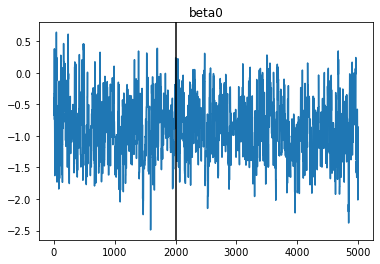

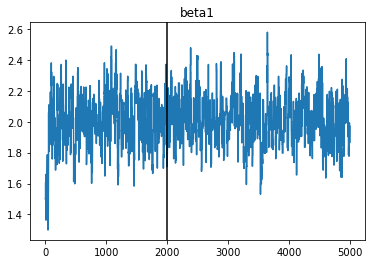

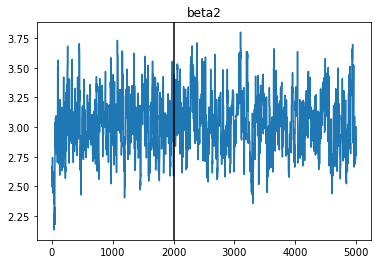

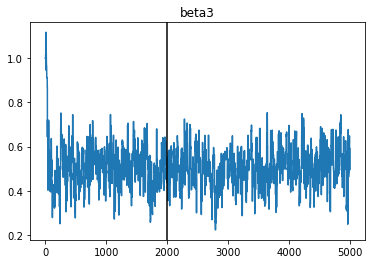

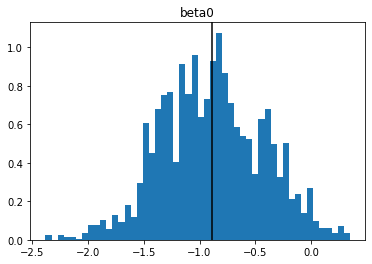

Beta0 Standard Deviation = 0.4567188295328844
Beta0 Mean = -0.8888795435298056


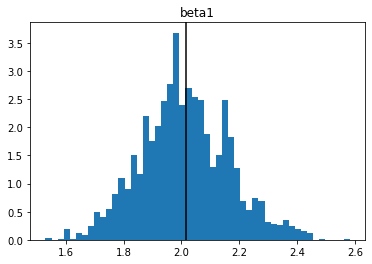

Beta1 Standard Deviation = 0.15250703455849182
Beta1 Mean = 2.012123653987514


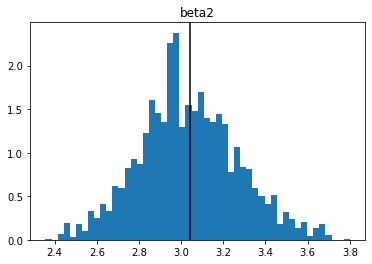

Beta2 Standard Deviation = 0.23444240056318286
Beta2 Mean = 3.0349600608232516


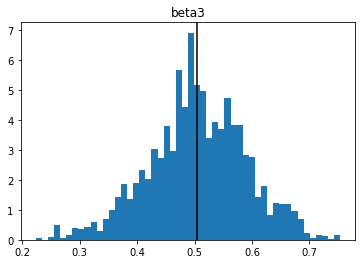

Beta3 Standard Deviation = 0.08475632294719757
Beta3 Mean = 0.504499513382757


In [325]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

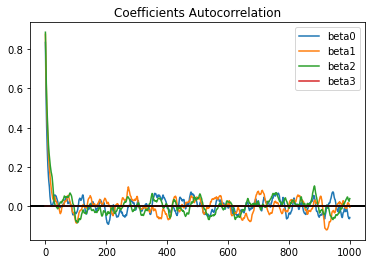

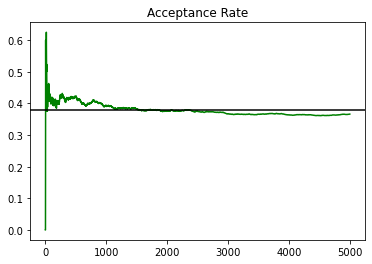

In [331]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [332]:
#Simulation 2: MCMC 2
X = covariates2(1000)
beta = np.array([-1,2,3,0.5])
y = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(y > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

iterations = 5000
b0 = np.array([0,0,0,0])

beta0 = np.zeros((4,))
v0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0],[0,0,0,1]])

c = MCMC(X, b0, iterations, beta0, v0) 
b = c[0]
acc = c[1]

Time: 80.05704736709595 seconds


The MSE is 0.010474480649255456


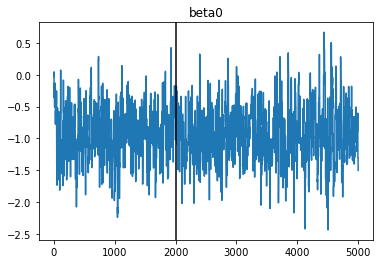

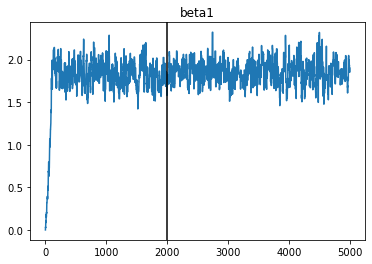

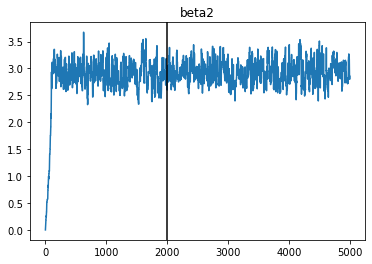

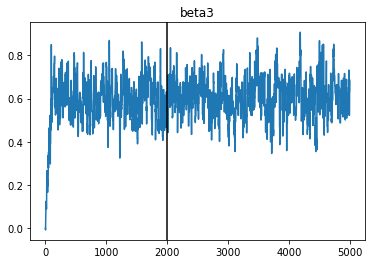

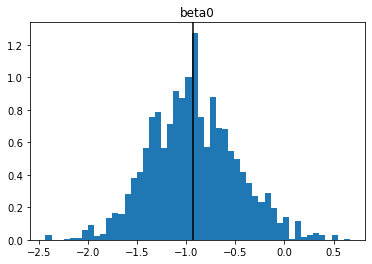

Beta0 Standard Deviation = 0.4442938466006047
Beta0 Mean = -0.9283751164469956


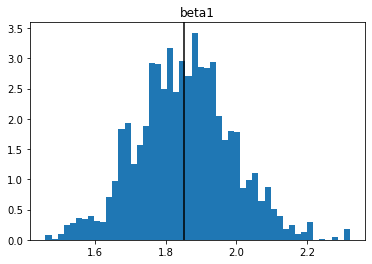

Beta1 Standard Deviation = 0.13412042121363832
Beta1 Mean = 1.8527350450692204


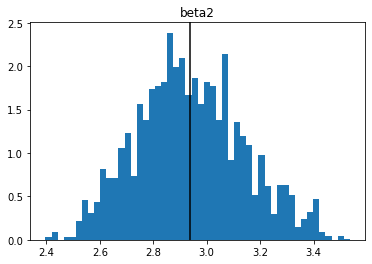

Beta2 Standard Deviation = 0.19965845241340116
Beta2 Mean = 2.9386688012113593


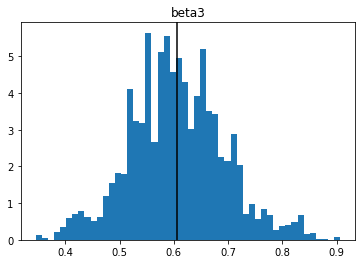

Beta3 Standard Deviation = 0.087074271012587
Beta3 Mean = 0.6063922730155911


In [333]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

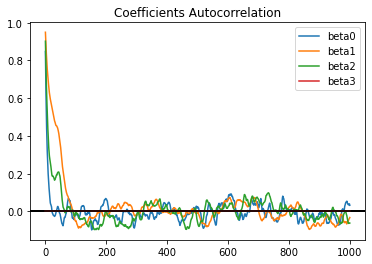

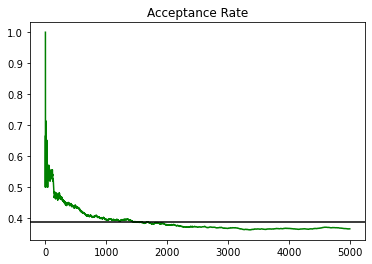

In [334]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc.mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [414]:
#Simulation 2: MCMC 3
X = covariates2(1000)
beta = np.array([-1,2,3,0.5])
y = np.dot(X, bo) + np.random.normal(size = (X.shape[0],))
Y = 1*(y > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

iterations = 5000
b0 = np.array([2,2,2,2])

beta0 = np.zeros((4,))
v0 = np.identity(4)

c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)
<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: divide by zero encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 84.87120580673218 seconds


The MSE is 0.03276717278781704


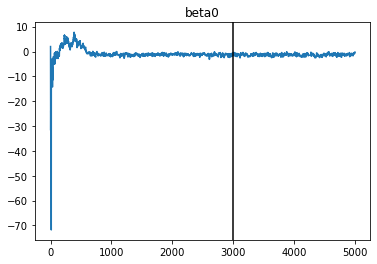

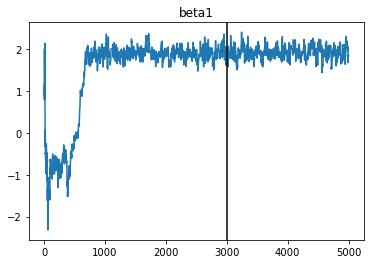

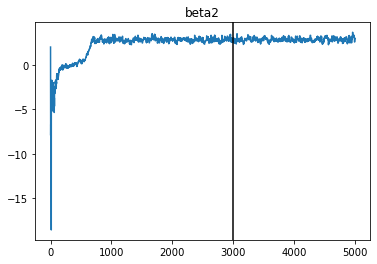

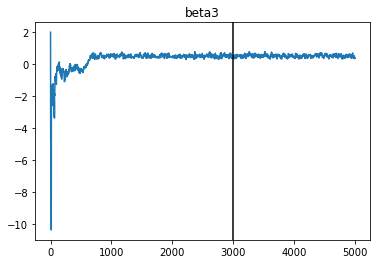

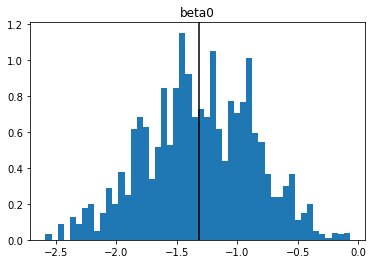

Beta0 Standard Deviation = 0.45162304654609553
Beta0 Mean = -1.3140743219047513


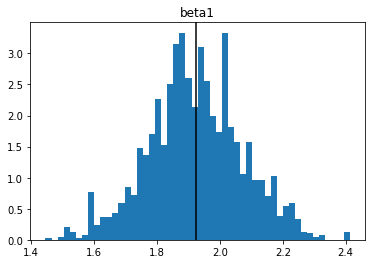

Beta1 Standard Deviation = 0.15020305823527375
Beta1 Mean = 1.9231915473513705


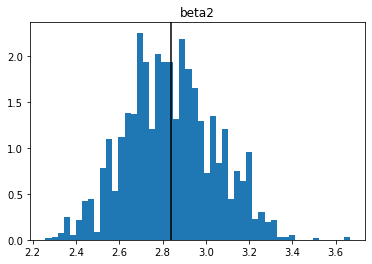

Beta2 Standard Deviation = 0.20669413320502728
Beta2 Mean = 2.8381792596596602


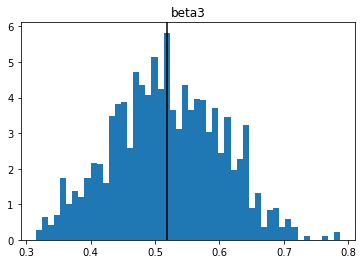

Beta3 Standard Deviation = 0.08428924721176521
Beta3 Mean = 0.5184532129659419


In [415]:
MSE = mean_squared_error(beta, np.array([b[3000:,0].mean(), b[3000:,1].mean(),b[3000:,2].mean(), b[3000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(3000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[3000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[3000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[3000:, i].std()}')
    print(f'Beta{i} Mean = {b[3000:, i].mean()}')

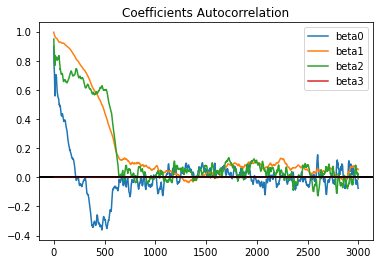

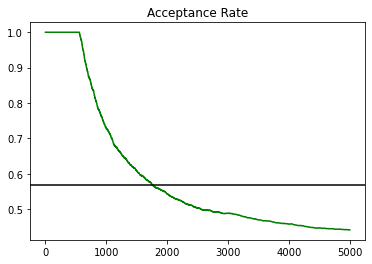

In [416]:
#Autocorrelation Analysis
corr0 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((3000,))
for i in range(3000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc[::-500].mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [411]:
#Simulation 2: MCMC 4
X = covariates2(1000)
beta = np.array([-1,2,3,0.5])
y = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(y > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

iterations = 5000
b0 = np.array([2,2,2,2])

beta0 = mean_target
v0 = np.identity(4)

c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 84.05735611915588 seconds


The MSE is 0.010519956562736198


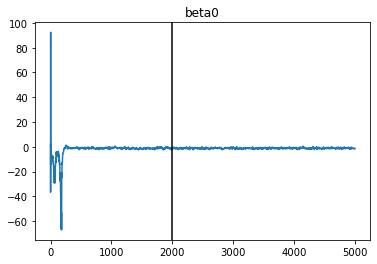

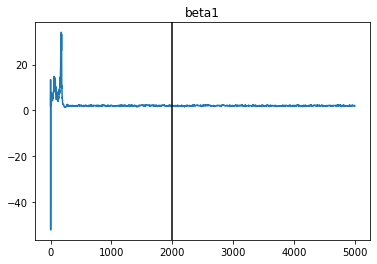

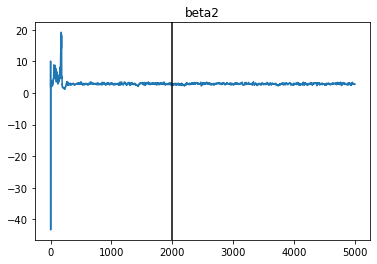

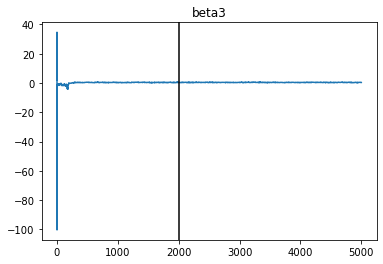

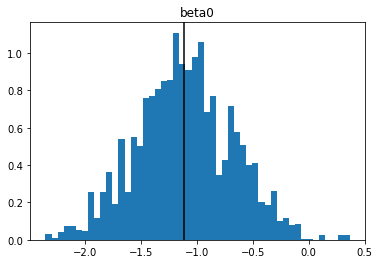

Beta0 Standard Deviation = 0.42946394319906395
Beta0 Mean = -1.1095834034900953


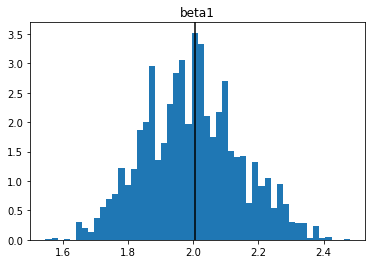

Beta1 Standard Deviation = 0.14696551549938683
Beta1 Mean = 1.9974132145954948


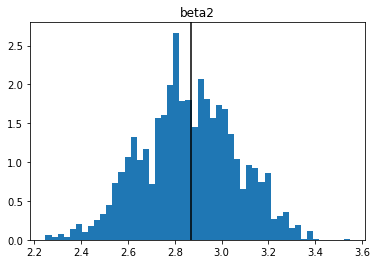

Beta2 Standard Deviation = 0.20357844638162542
Beta2 Mean = 2.861331049912522


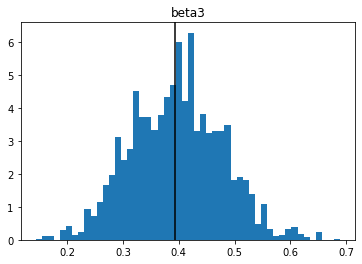

Beta3 Standard Deviation = 0.08216124893725749
Beta3 Mean = 0.3959061252840528


In [412]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1500:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

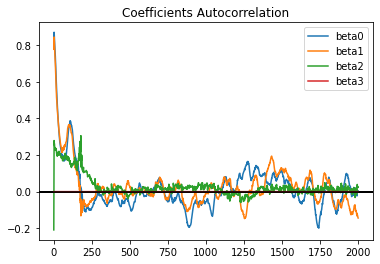

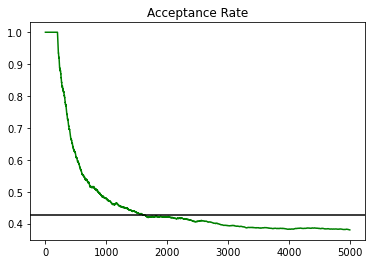

In [413]:
#Autocorrelation Analysis
corr0 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((2000,))
for i in range(2000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc, color = 'g')
plt.axhline(acc[::-500].mean(), color = 'k')
plt.title('Acceptance Rate')
plt.show()

In [ ]:
#Simulation 2: Uninformed Gibbs 1
X = covariates2(3000)
beta = np.array([-1,2,3,0.5])
y = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(y > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

iterations = 5000
b0 = np.array([2,2,2,2])

b = uninformed_gibbs(X, b0, iterations)

The MSE is 0.05263040293769704


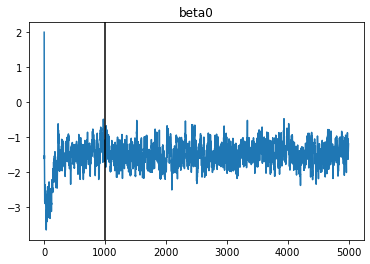

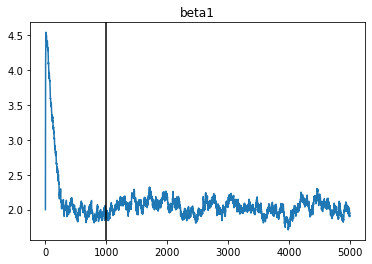

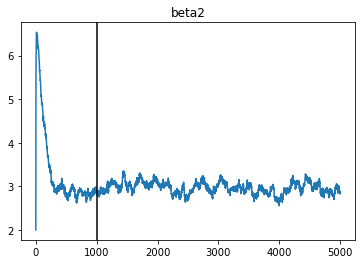

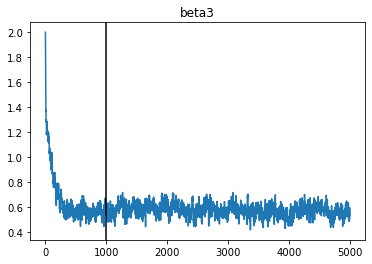

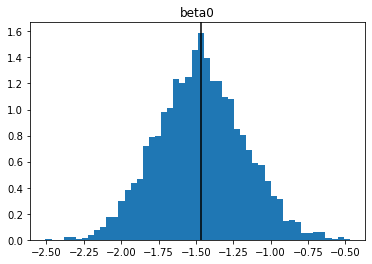

Beta0 Standard Deviation = 0.2918672377365335
Beta0 Mean = -1.4499270363401364


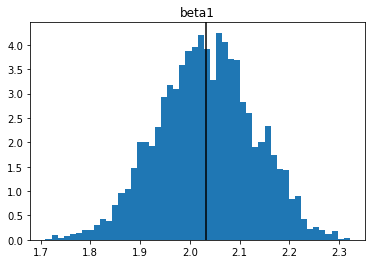

Beta1 Standard Deviation = 0.09498001125356974
Beta1 Mean = 2.0163559239014037


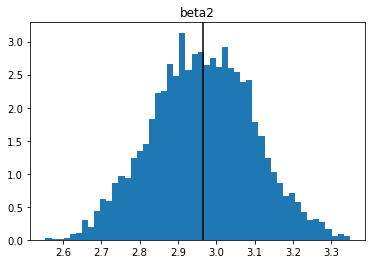

Beta2 Standard Deviation = 0.1273670303410331
Beta2 Mean = 2.942060323967988


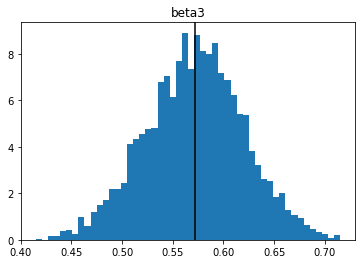

Beta3 Standard Deviation = 0.04769357233992398
Beta3 Mean = 0.566803827851454


In [375]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

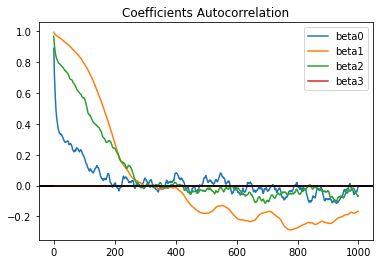

In [376]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [379]:
#Simulation 2: Uninformed Gibbs 2
iterations = 5000
b0 = np.array([2,0,1,2.5])
b = uninformed_gibbs(X, b0, iterations)

Time: 20.405482292175293 seconds


The MSE is 0.061729979345224846


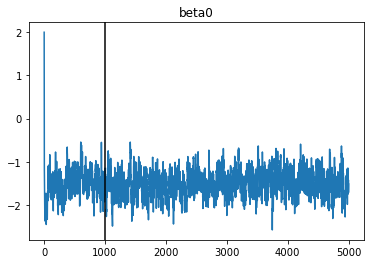

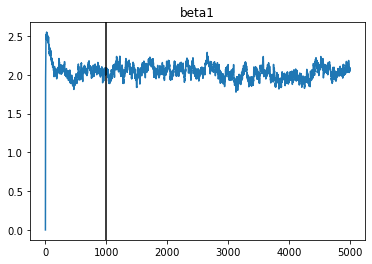

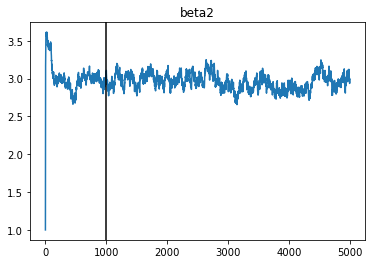

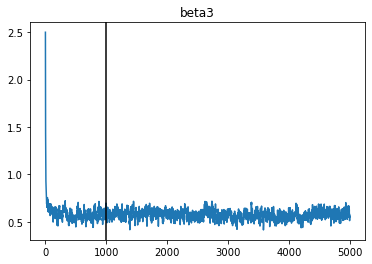

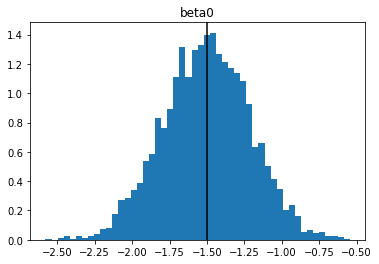

Beta0 Standard Deviation = 0.28238793951509844
Beta0 Mean = -1.488214848209536


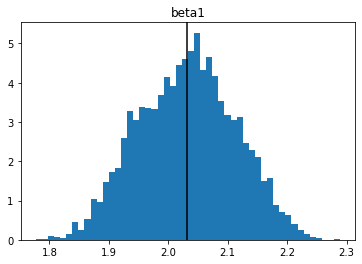

Beta1 Standard Deviation = 0.08143285483179434
Beta1 Mean = 2.022489289215009


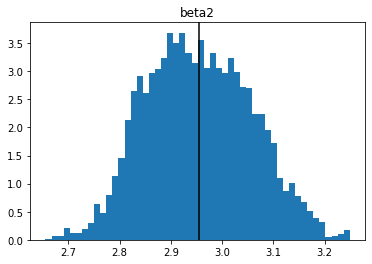

Beta2 Standard Deviation = 0.10443605304973373
Beta2 Mean = 2.9424067615039604


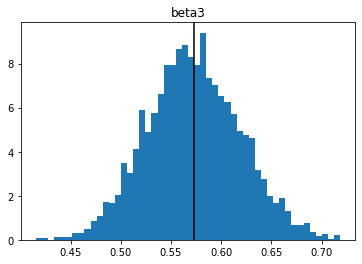

Beta3 Standard Deviation = 0.04647301468151561
Beta3 Mean = 0.5688725643400985


In [380]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

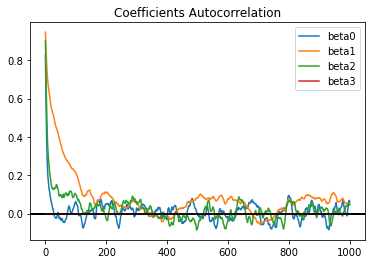

In [381]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [387]:
#Simulation 2: Uninformed Gibbs 3
iterations = 5000
b0 = np.array([0,0,0,0])
b = uninformed_gibbs(X, b0, iterations)

Time: 19.06475305557251 seconds


The MSE is 0.04006773105620584


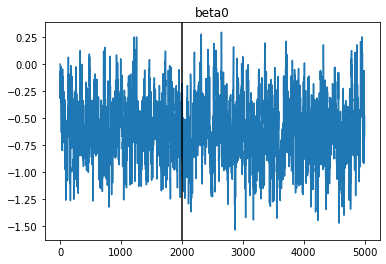

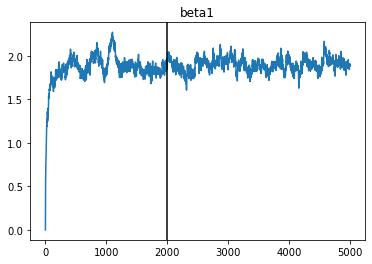

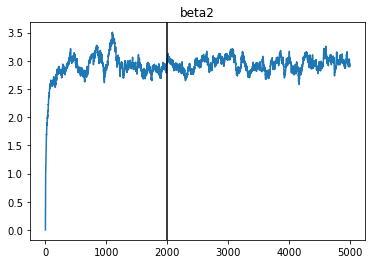

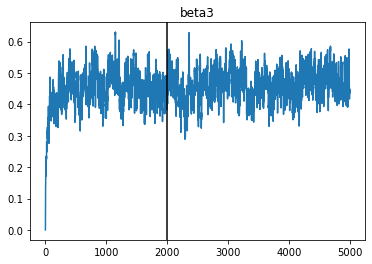

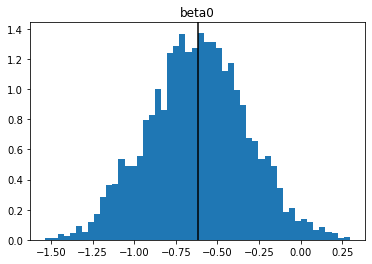

Beta0 Standard Deviation = 0.29512260963012177
Beta0 Mean = -0.6191309232099209


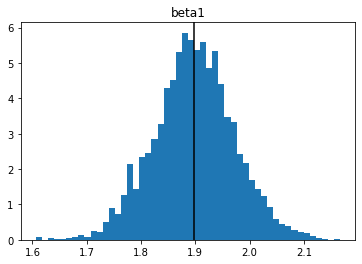

Beta1 Standard Deviation = 0.07462376013813213
Beta1 Mean = 1.8976451615972922


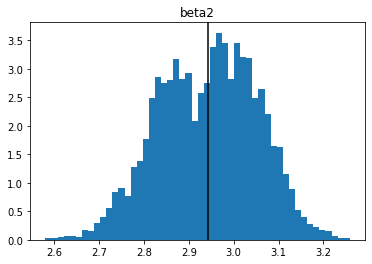

Beta2 Standard Deviation = 0.10978751219307234
Beta2 Mean = 2.942147618720737


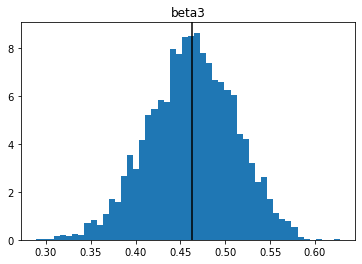

Beta3 Standard Deviation = 0.048051880346155436
Beta3 Mean = 0.46276749262041844


In [388]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()
    
for i in range(4):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

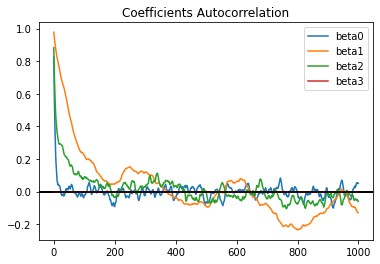

In [389]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [393]:
#Simulation 2: Informed Gibbs 1
X = covariates2(3000)
beta = np.array([-1,2,3,0.5])
y = np.dot(X, beta) + np.random.normal(size = (X.shape[0],))
Y = 1*(y > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

iterations = 5000
b0 = np.array([0,0,0,0])
#Standard Normal
beta0 = np.zeros((4,))
v0 = np.identity(4)
b = informed_gibbs(X, b0, iterations, beta0, v0)

Time: 17.42243480682373 seconds


The MSE is 0.011110982323125077


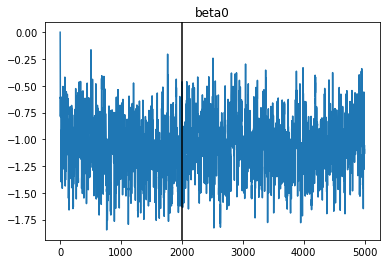

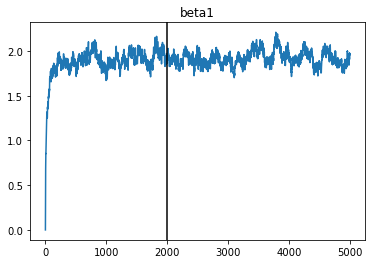

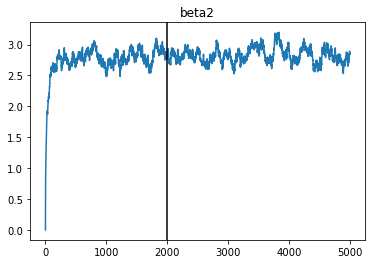

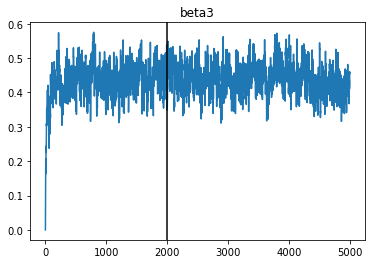

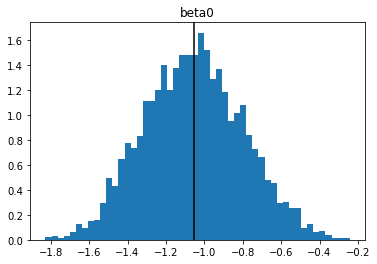

Beta0 Standard Deviation = 0.25644263741439977
Beta0 Mean = -1.0551292553614302


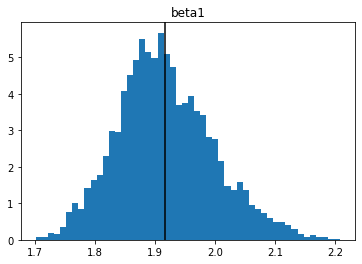

Beta1 Standard Deviation = 0.08011526023371804
Beta1 Mean = 1.9173795750902767


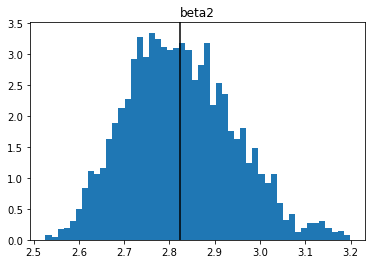

Beta2 Standard Deviation = 0.11864943509073755
Beta2 Mean = 2.8242134023171213


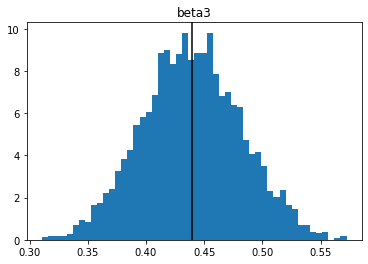

Beta3 Standard Deviation = 0.042410755509342396
Beta3 Mean = 0.4393565175916733


In [394]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(2000, color = 'k')
    plt.show()

for i in range(4):
    plt.hist(b[2000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[2000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

In [395]:
#Simulation 2: Informed Gibbs 2
iterations = 5000
b0 = np.array([0,0,0,0])
beta0 = mean_target
v0 = cov_target
b = informed_gibbs(X, b0, iterations, beta0, v0)
#A proper prior guarantees a quicker and more precise convergence.

Time: 19.658921003341675 seconds


The MSE is 0.002134990067705884


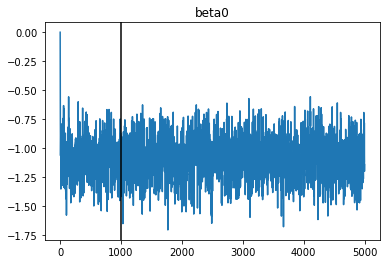

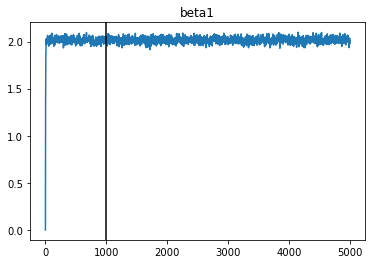

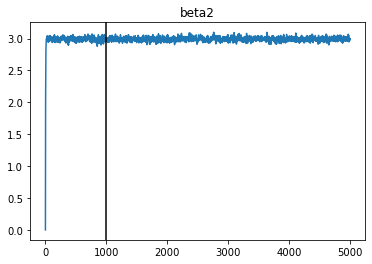

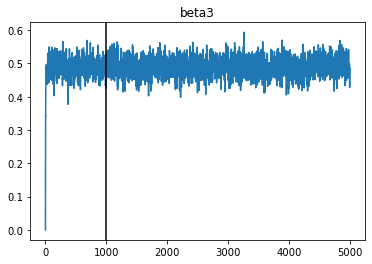

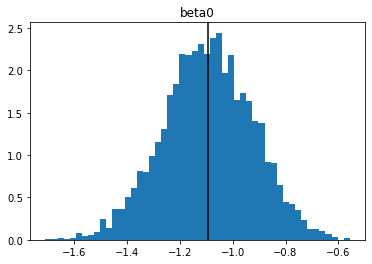

Beta0 Standard Deviation = 0.16949540916605477
Beta0 Mean = -1.0903660114485239


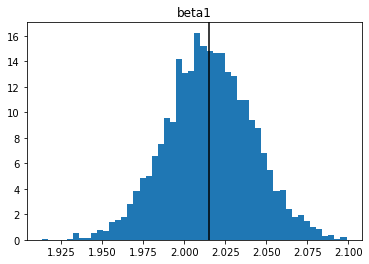

Beta1 Standard Deviation = 0.02615740707218465
Beta1 Mean = 2.015482442474003


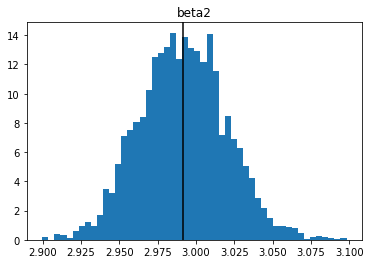

Beta2 Standard Deviation = 0.028682169978779638
Beta2 Mean = 2.9926917719752866


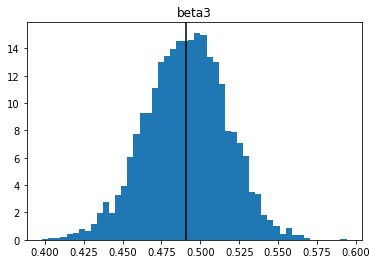

Beta3 Standard Deviation = 0.0261217392677404
Beta3 Mean = 0.4910095593051972


In [396]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean()]))
print(f'The MSE is {MSE}')

for i in range(4):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(4):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

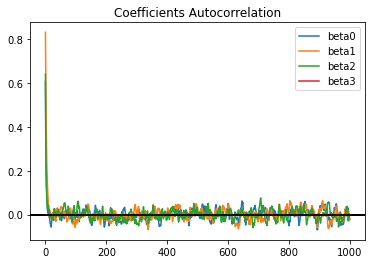

In [397]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

# Simulation 3

In [513]:
import pandas as pd
import numpy as np
df = pd.read_csv('Gaming.csv')
df.head()

id gender  household_annual_income  age  proportion_gaming_products  \
0  24994      F                46013.578   29                    0.000000   
1  25501      M                37447.980   38                    1.000000   
2  10571      F                37138.875   37                    0.428948   
3  22832      M                28977.809   32                    0.000000   
4  20265      M                36095.945   30                    0.000000   

   previous_purchase_gaming_pc choice  purchase  ln_income  male  A  
0                            0      B         1  10.736691     0  0  
1                            0   None         0  10.530708     1  0  
2                            0   None         0  10.522420     0  0  
3                            0   None         0  10.274285     1  0  
4                            0   None         0  10.493936     1  0

In [514]:
df['id'] = 1
df.drop('gender', axis = 1, inplace = True)
df.drop('household_annual_income', axis = 1, inplace = True)
df.drop('purchase', axis = 1, inplace = True)
df = df[df['choice'] != 'None']
Y = 1*(df['choice'] == 'A')

In [515]:
df.drop('choice', axis = 1, inplace = True)
df.drop('A', axis = 1, inplace = True)

In [520]:
#Simulation 3
#Distribution of OLS estimators
X = np.array(df)
beta = np.array([4.17425, 0.2783464, -0.9335337, 0.5112991, -1.14485, -0.2623994])
beta0 = np.zeros((10000,))
beta1 = np.zeros((10000,))
beta2 = np.zeros((10000,))
beta3 = np.zeros((10000,))
beta4 = np.zeros((10000,))
beta5 = np.zeros((10000,))
for i in range(10000):
    latent = np.dot(X, beta) + np.random.normal(size = (3103,))
    regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))
    beta0[i] = regb[0]
    beta1[i] = regb[1]
    beta2[i] = regb[2]
    beta3[i] = regb[3]
    beta4[i] = regb[4]
    beta5[i] = regb[5]

print([np.mean(beta0), np.mean(beta1), np.mean(beta2), np.mean(beta3), np.mean(beta4), np.mean(beta5)])
print(regb)

[4.164559502258598, 0.27840926317026526, -0.9336957412957563, 0.5113930935100982, -1.144146239785583, -0.2618978432042447]
[ 3.45333137  0.28690696 -0.90888142  0.53178566 -1.10305177 -0.3035752 ]


In [521]:
#Target Distribution Analysis (Referred to Simulation 3)
import pandas as pd
mean_target = np.array([np.mean(beta0), np.mean(beta1), np.mean(beta2), np.mean(beta3), np.mean(beta4), np.mean(beta5)])
beta_all = np.array([beta0, beta1, beta2, beta3, beta4, beta5]).T
cov_target = pd.DataFrame(beta_all).cov()
cov_target = np.array(cov_target)
cov_target
print(f'The mean of the target is \n{mean_target}')
print(f'The variance-covariance matrix of the target is \n{cov_target}')

The mean of the target is 
[ 4.1645595   0.27840926 -0.93369574  0.51139309 -1.14414624 -0.26189784]
The variance-covariance matrix of the target is 
[[ 2.19428383e+00 -6.15020832e-04  2.29795032e-03 -2.79036755e-04
  -2.06062551e-01 -7.34936808e-04]
 [-6.15020832e-04  4.84036027e-05 -8.59878656e-05 -3.43881309e-05
  -7.86469129e-05 -5.94031755e-05]
 [ 2.29795032e-03 -8.59878656e-05  1.72089515e-03  1.36374210e-04
  -5.67827690e-05  1.32812670e-04]
 [-2.79036755e-04 -3.43881309e-05  1.36374210e-04  1.57185628e-03
   7.64963677e-05  3.88976744e-05]
 [-2.06062551e-01 -7.86469129e-05 -5.67827690e-05  7.64963677e-05
   1.97496655e-02  1.59364126e-04]
 [-7.34936808e-04 -5.94031755e-05  1.32812670e-04  3.88976744e-05
   1.59364126e-04  1.42238957e-03]]


In [468]:
#Simulation 3: MCMC 1
X = np.array(df)

beta0 = beta*0.7
v0 = np.identity(6)

b0 = np.array([0,0,0,0,0,0])
iterations = 2000
print(X.shape)
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

(3103, 6)


<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 265.5371491909027 seconds


The MSE is 296.58294150061596


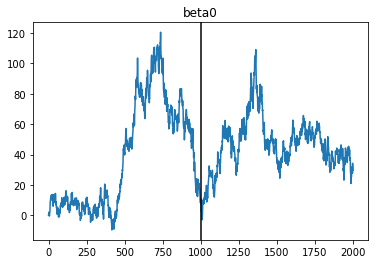

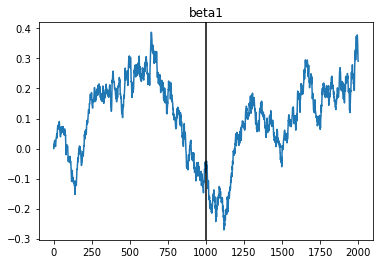

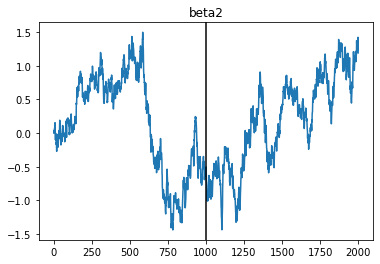

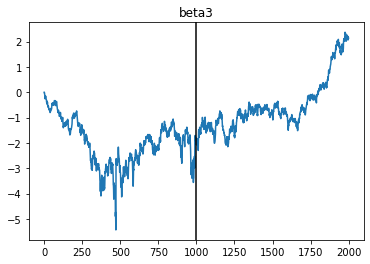

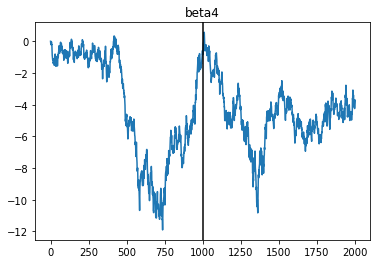

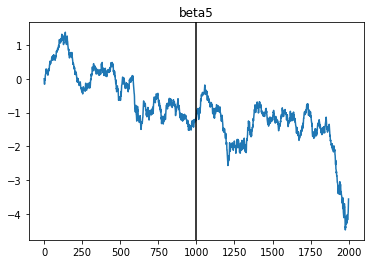

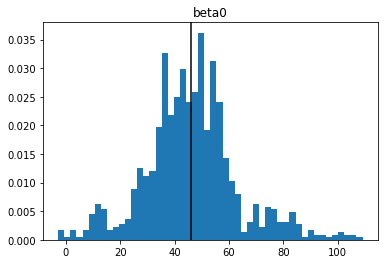

Beta0 Standard Deviation = 17.13473315632224
Beta0 Mean = 46.16824889400465


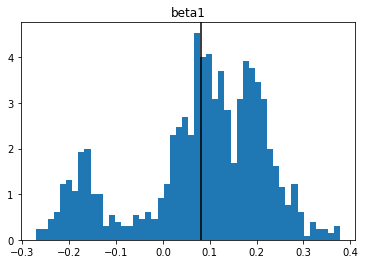

Beta1 Standard Deviation = 0.1379858878566703
Beta1 Mean = 0.08158977870785808


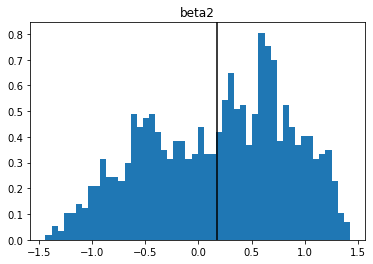

Beta2 Standard Deviation = 0.6641478616126215
Beta2 Mean = 0.17744042074302718


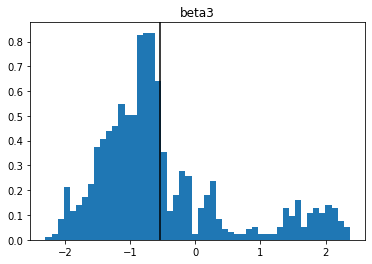

Beta3 Standard Deviation = 1.0204817370927968
Beta3 Mean = -0.53305571539506


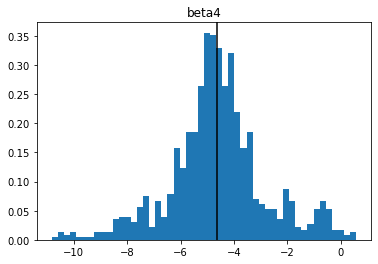

Beta4 Standard Deviation = 1.8095462366391606
Beta4 Mean = -4.620982219212569


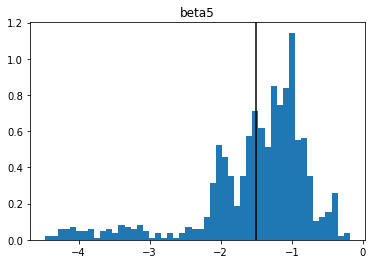

Beta5 Standard Deviation = 0.7796508428514201
Beta5 Mean = -1.50921816917328


In [469]:
MSE = mean_squared_error(beta, np.array([b[1000:,0].mean(), b[1000:,1].mean(),b[1000:,2].mean(), b[1000:,3].mean(), b[1000:,4].mean(), b[1000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[1000:, i].std()}')
    print(f'Beta{i} Mean = {b[1000:, i].mean()}')

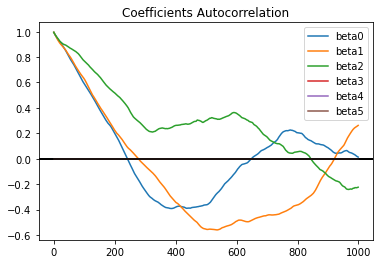

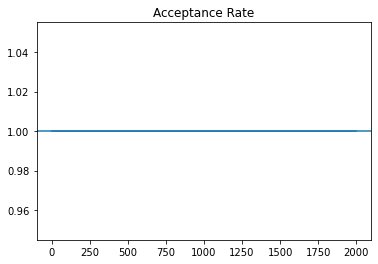

In [471]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(1999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(1999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(1999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc)
plt.title('Acceptance Rate')
plt.axhline(acc[::-100].mean())
plt.show()

In [522]:
#MCMC 2
X = np.array(df)

beta0 = beta*0.8
v0 = cov_target

b0 = beta*0.6
iterations = 2000
print(X.shape)
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

(3103, 6)


<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 248.24204564094543 seconds


The MSE is 57285.44024720429


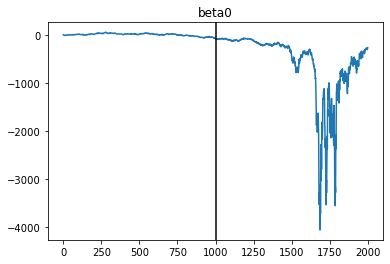

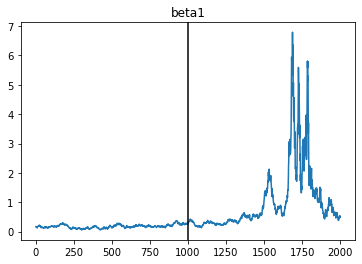

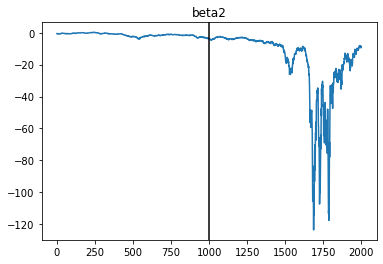

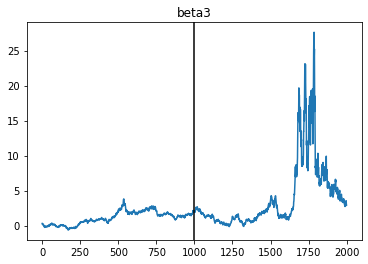

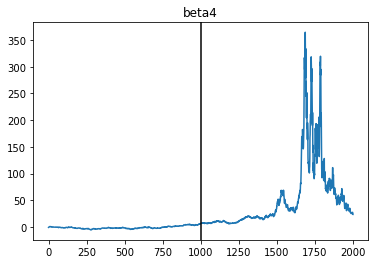

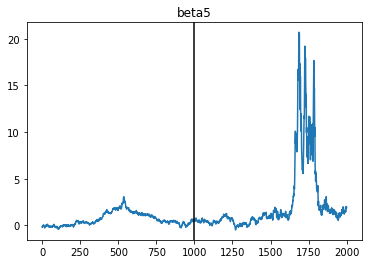

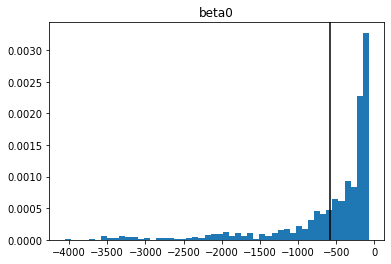

Beta0 Standard Deviation = 704.5882942671996
Beta0 Mean = -579.4168060137417


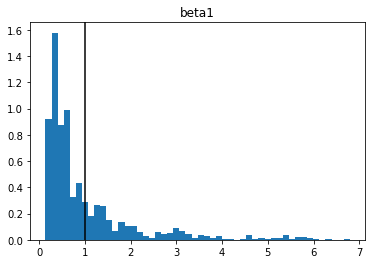

Beta1 Standard Deviation = 1.106402075095336
Beta1 Mean = 1.0089584760862413


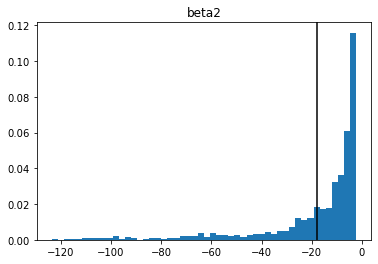

Beta2 Standard Deviation = 21.95440703964785
Beta2 Mean = -17.974167362414367


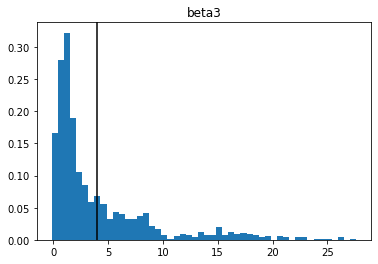

Beta3 Standard Deviation = 4.807244784340749
Beta3 Mean = 3.9781373377221394


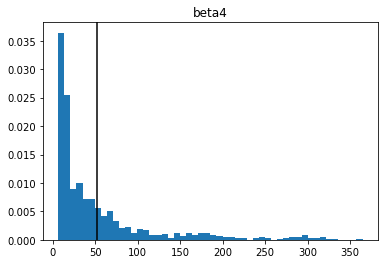

Beta4 Standard Deviation = 63.50697048209238
Beta4 Mean = 52.00111057268793


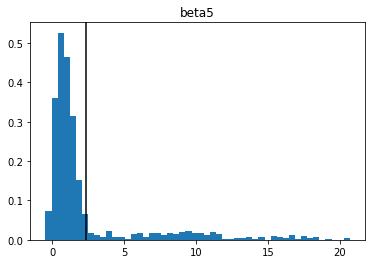

Beta5 Standard Deviation = 3.767649433538754
Beta5 Mean = 2.3244407204754327


In [525]:
MSE = mean_squared_error(beta, np.array([b[1000:,0].mean(), b[1000:,1].mean(),b[1000:,2].mean(), b[1000:,3].mean(), b[1000:,4].mean(), b[1000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[1000:, i].std()}')
    print(f'Beta{i} Mean = {b[1000:, i].mean()}')

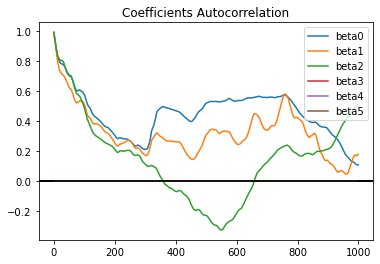

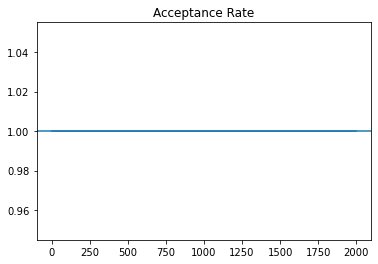

In [526]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(1999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(1999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(1999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc)
plt.title('Acceptance Rate')
plt.axhline(acc[::-100].mean())
plt.show()

In [517]:
#MCMC 3
X = np.array(df)

beta0 = beta*0.5
v0 = np.identity(6)

b0 = beta*0.9
iterations = 2000
print(X.shape)
c = MCMC(X, b0, iterations, beta0, v0)
b = c[0]
acc = c[1]

(3103, 6)


<ipython-input-253-e681e8b9af47>:37: RuntimeWarning: invalid value encountered in double_scalars
  acc_ratio = (like1*prior1)/(like0*prior0)


Time: 251.24108910560608 seconds


The MSE is 35.359537097721756


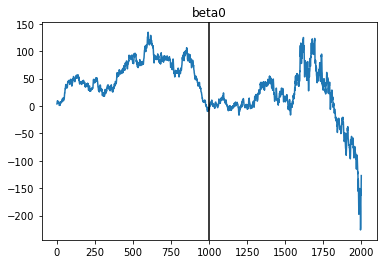

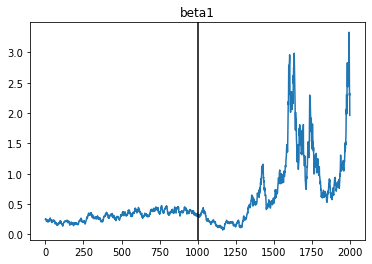

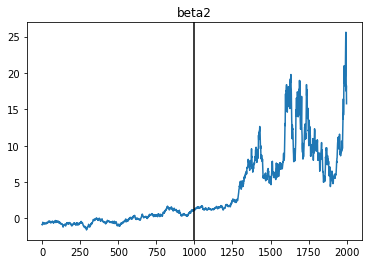

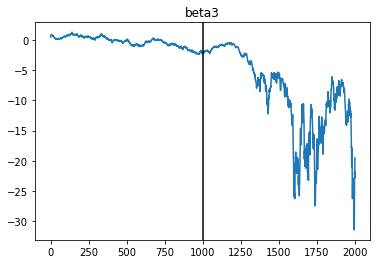

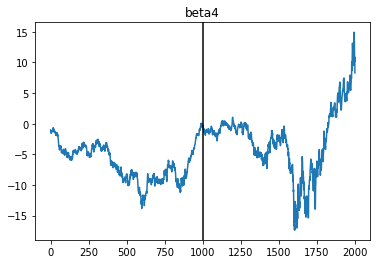

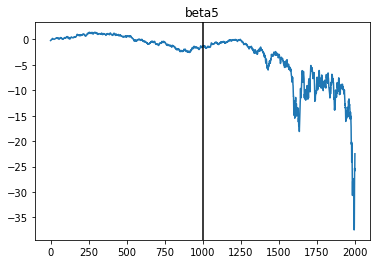

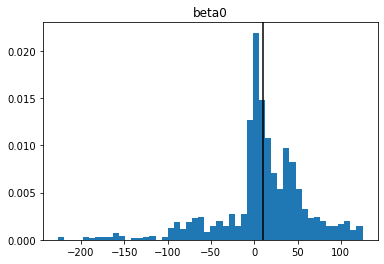

Beta0 Standard Deviation = 50.73746809192624
Beta0 Mean = 9.793679656050717


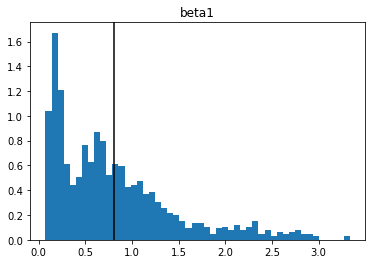

Beta1 Standard Deviation = 0.6455523747811982
Beta1 Mean = 0.8038687428652754


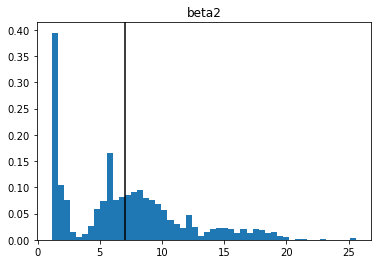

Beta2 Standard Deviation = 4.807356641758383
Beta2 Mean = 7.06249814260755


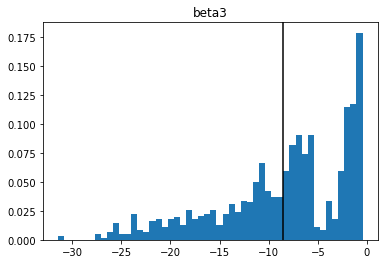

Beta3 Standard Deviation = 6.740904304660033
Beta3 Mean = -8.593591161003909


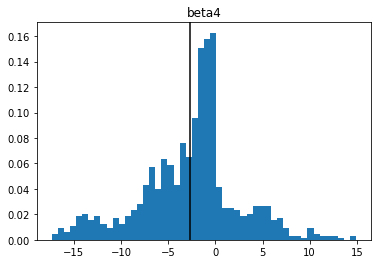

Beta4 Standard Deviation = 5.270004580565497
Beta4 Mean = -2.6545665461947383


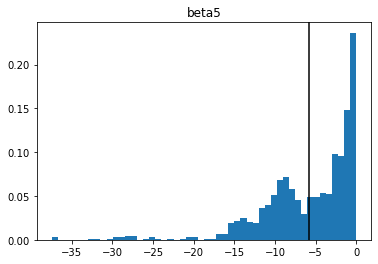

Beta5 Standard Deviation = 5.6699151972973825
Beta5 Mean = -5.847044711155019


In [518]:
MSE = mean_squared_error(beta, np.array([b[1000:,0].mean(), b[1000:,1].mean(),b[1000:,2].mean(), b[1000:,3].mean(), b[1000:,4].mean(), b[1000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[1000:, i].std()}')
    print(f'Beta{i} Mean = {b[1000:, i].mean()}')

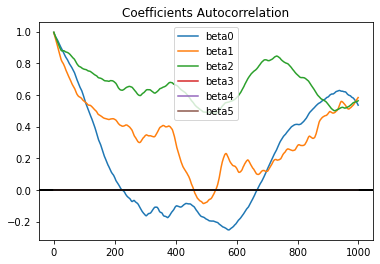

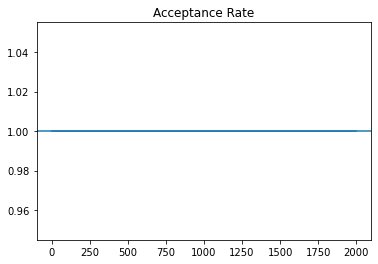

In [519]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(1999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(1999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(1999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(1999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

plt.plot(acc)
plt.title('Acceptance Rate')
plt.axhline(acc[::-100].mean())
plt.show()

In [421]:
# Simulation 3: Uninformed Gibbs 1
X = np.array(df)
beta0 = np.zeros((6,))
v0 = np.identity(6)
b0 = np.array([0,0,0,0,0,0])
iterations = 5000
print(X.shape)
b = uninformed_gibbs(X, b0, iterations)

(3103, 6)
Time: 37.28786540031433 seconds


The MSE is 0.001178628072374522


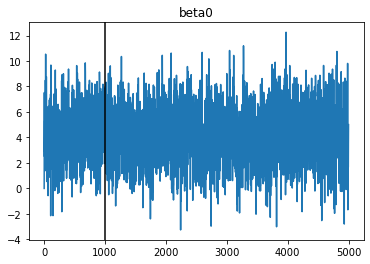

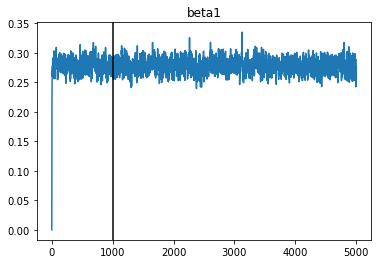

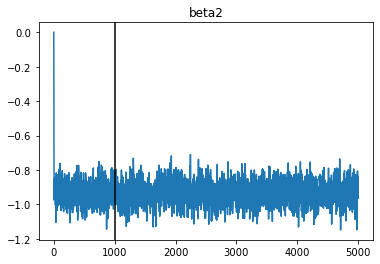

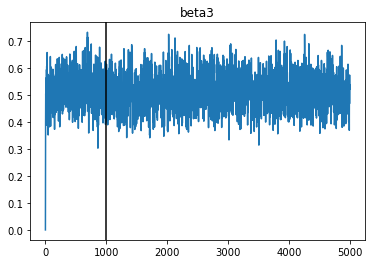

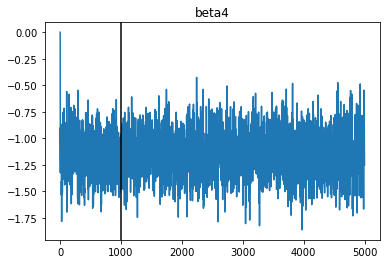

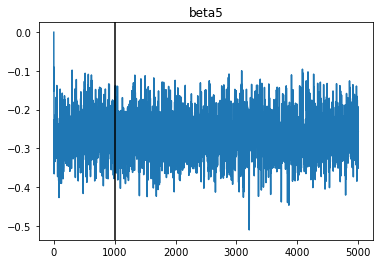

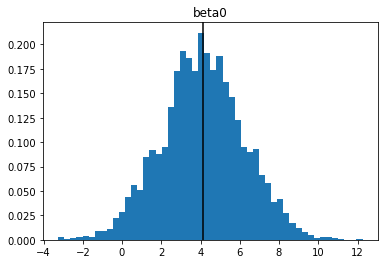

Beta0 Standard Deviation = 2.1379390758963424
Beta0 Mean = 4.090581469693557


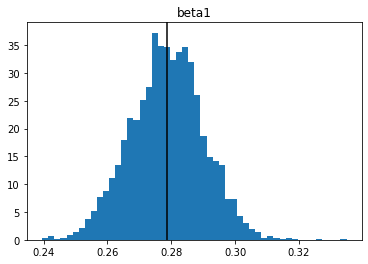

Beta1 Standard Deviation = 0.01133202061377154
Beta1 Mean = 0.27856495505989537


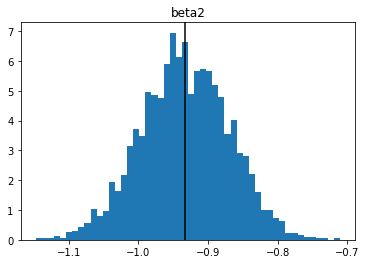

Beta2 Standard Deviation = 0.06288130643918807
Beta2 Mean = -0.9336095049325261


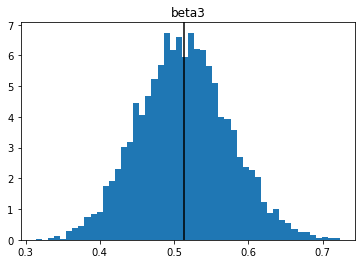

Beta3 Standard Deviation = 0.061257253140462015
Beta3 Mean = 0.5148614792459296


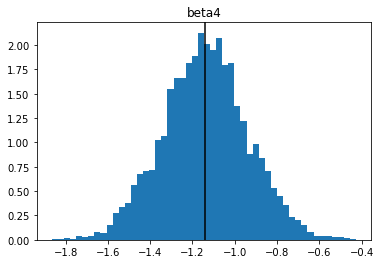

Beta4 Standard Deviation = 0.2044308776070208
Beta4 Mean = -1.1374238864367272


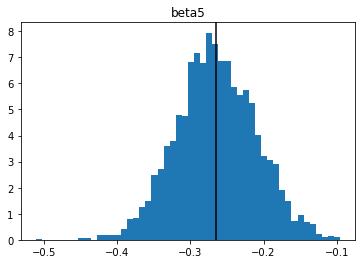

Beta5 Standard Deviation = 0.053607537176056826
Beta5 Mean = -0.2642579610989615


In [424]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean(), b[2000:,4].mean(), b[2000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

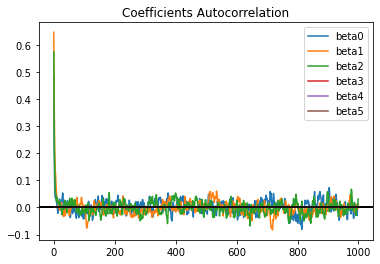

In [425]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [455]:
#Simulation 3: Uninformed Gibbs 2
X = np.array(df)
b0 = beta*2
iterations = 5000
print(b0)
b = uninformed_gibbs(X, b0, iterations)

[ 8.3485     0.5566928 -1.8670674  1.0225982 -2.2897    -0.5247988]
Time: 37.24074411392212 seconds


The MSE is 5.091900722627938e-05


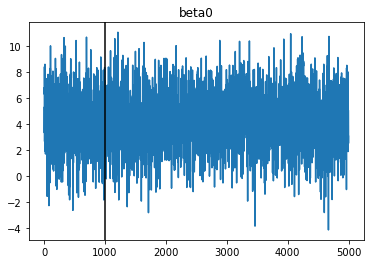

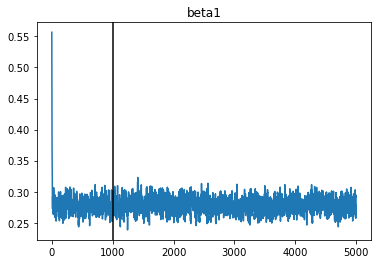

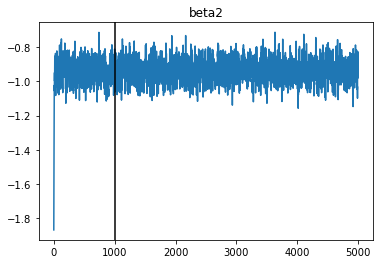

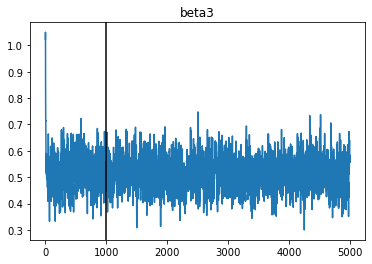

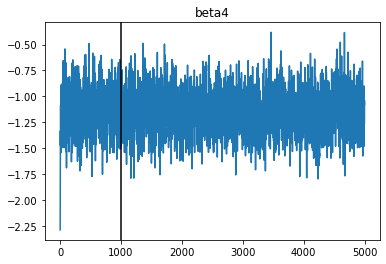

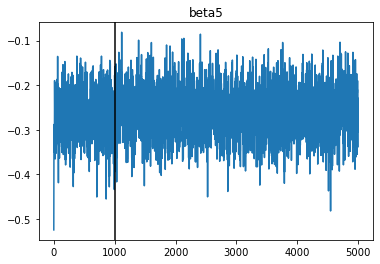

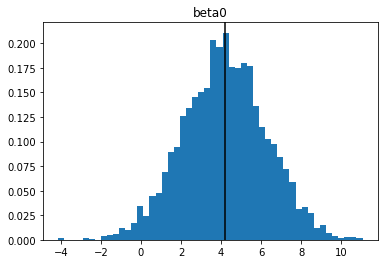

Beta0 Standard Deviation = 2.054468604463455
Beta0 Mean = 4.191483699328729


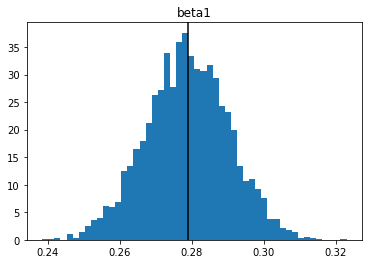

Beta1 Standard Deviation = 0.011243251601415132
Beta1 Mean = 0.27838346201350633


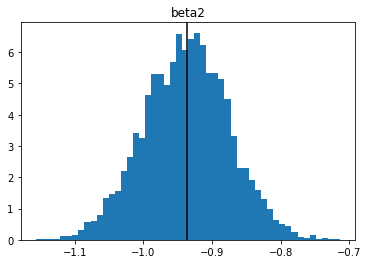

Beta2 Standard Deviation = 0.06190924052663418
Beta2 Mean = -0.9356885988969058


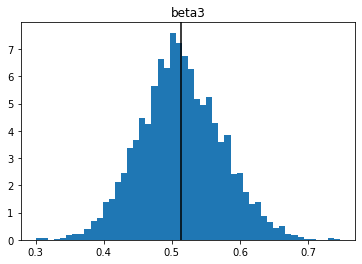

Beta3 Standard Deviation = 0.05940533243699205
Beta3 Mean = 0.5120055995029921


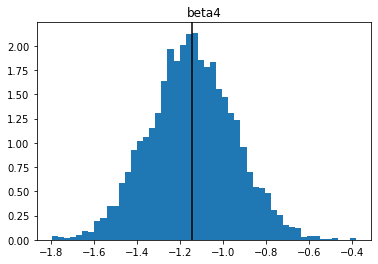

Beta4 Standard Deviation = 0.19560417996504526
Beta4 Mean = -1.146563254643754


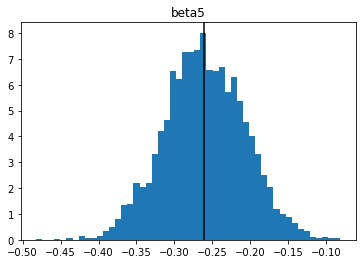

Beta5 Standard Deviation = 0.052357875182726596
Beta5 Mean = -0.26174038184104625


In [456]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean(), b[2000:,4].mean(), b[2000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

In [457]:
#Simulation 3: Uninformed Gibbs 3
X = np.array(df)
b0 = beta*3.7
iterations = 5000
print(b0)
b = uninformed_gibbs(X, b0, iterations)

[15.444725    1.02988168 -3.45407469  1.89180667 -4.235945   -0.97087778]
Time: 37.71411681175232 seconds


The MSE is 5.282899672695802e-05


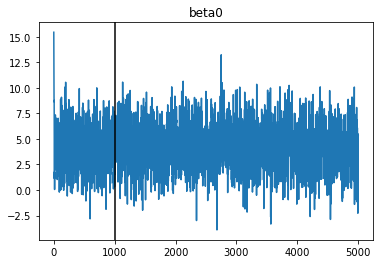

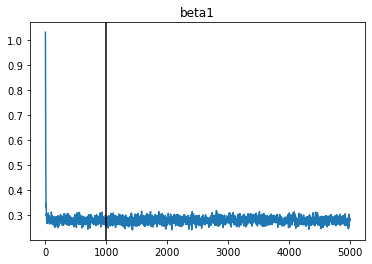

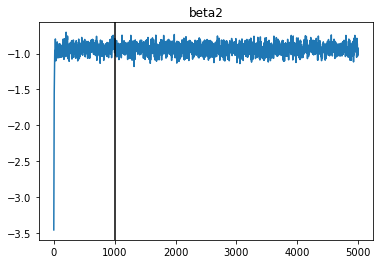

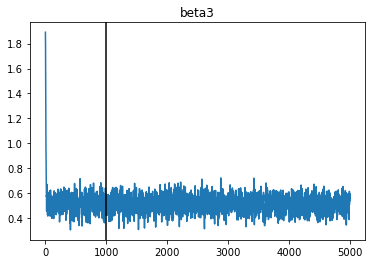

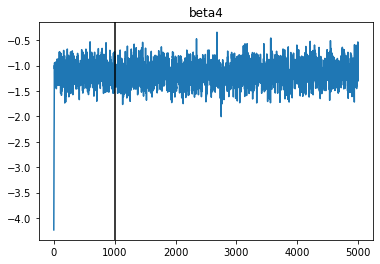

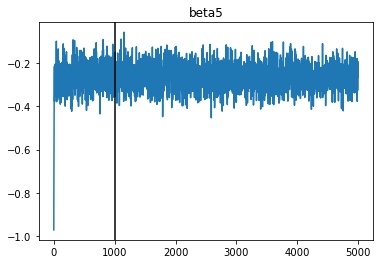

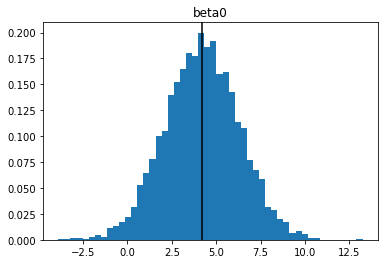

Beta0 Standard Deviation = 2.089298648590237
Beta0 Mean = 4.191488648747335


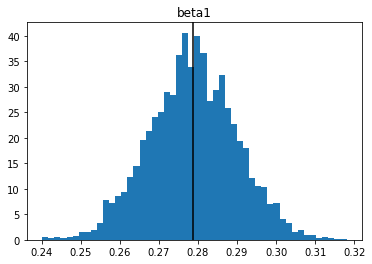

Beta1 Standard Deviation = 0.011041066969897236
Beta1 Mean = 0.2788611491392943


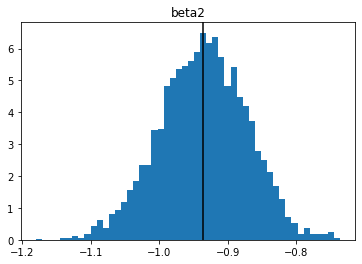

Beta2 Standard Deviation = 0.06337919413284918
Beta2 Mean = -0.9360062885836717


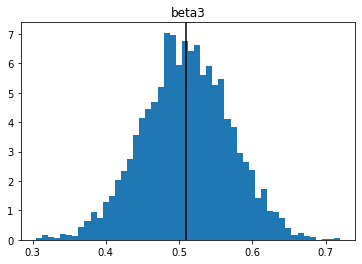

Beta3 Standard Deviation = 0.05966252268435583
Beta3 Mean = 0.510102800430088


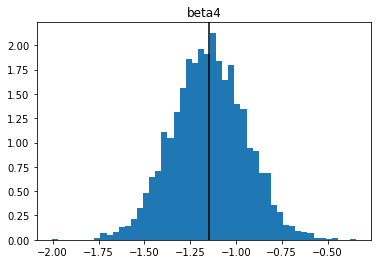

Beta4 Standard Deviation = 0.19954474792017557
Beta4 Mean = -1.147644106094446


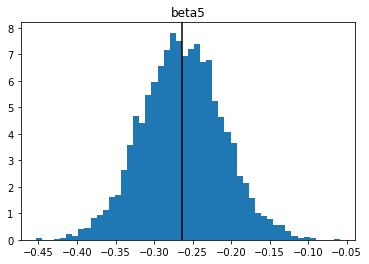

Beta5 Standard Deviation = 0.05118001227076671
Beta5 Mean = -0.2644454076293258


In [459]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean(), b[2000:,4].mean(), b[2000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

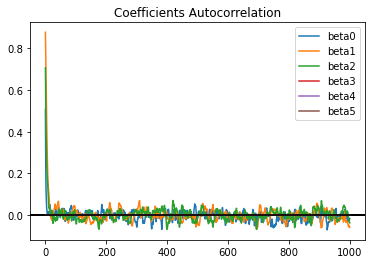

In [460]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [461]:
#Simulation 3: Informed Gibbs 1
X = np.array(df)

beta0 = np.zeros((6,))
v0 = np.identity(6)

b0 = beta*3.7
iterations = 5000
print(X.shape)
b = informed_gibbs(X, b0, iterations, beta0, v0)

(3103, 6)
Time: 37.146031618118286 seconds


The MSE is 2.001515672453689


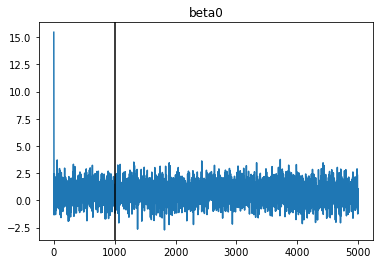

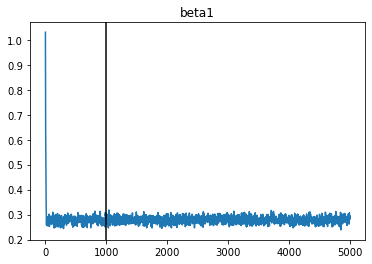

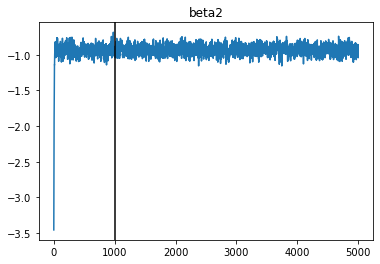

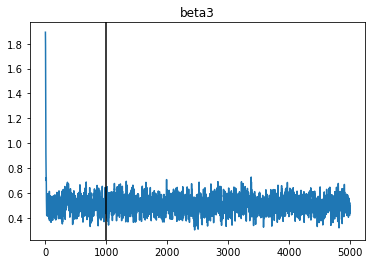

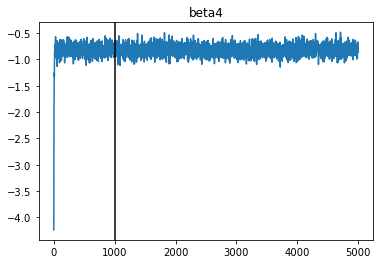

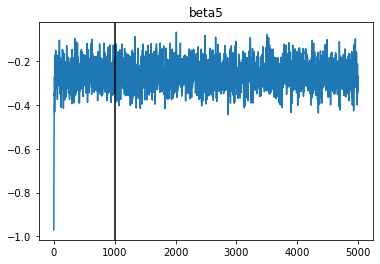

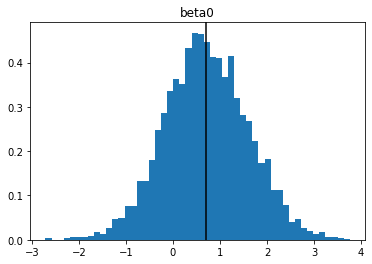

Beta0 Standard Deviation = 0.891110743057428
Beta0 Mean = 0.7239960882777328


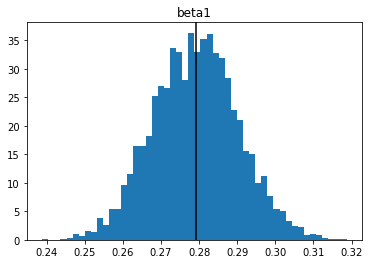

Beta1 Standard Deviation = 0.011228194238947603
Beta1 Mean = 0.27926962405643785


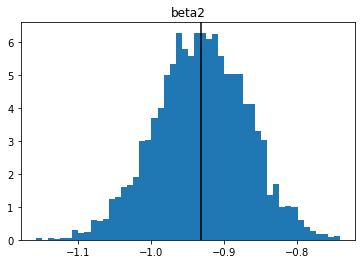

Beta2 Standard Deviation = 0.06309792556292175
Beta2 Mean = -0.9306358015189043


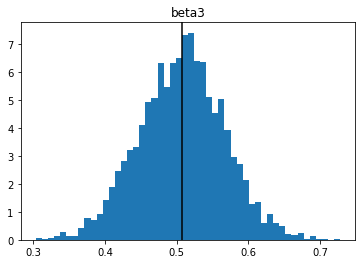

Beta3 Standard Deviation = 0.05950896703999713
Beta3 Mean = 0.5066344608983268


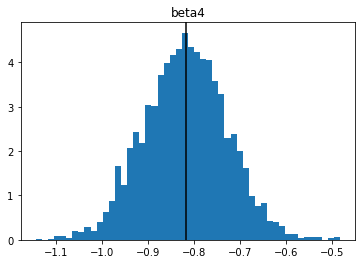

Beta4 Standard Deviation = 0.08938323309850373
Beta4 Mean = -0.8211203546343442


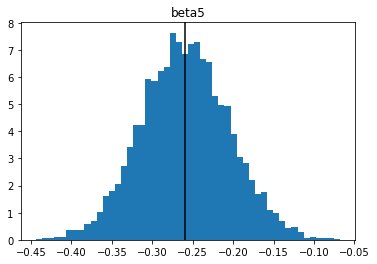

Beta5 Standard Deviation = 0.0541477052735656
Beta5 Mean = -0.25922338637568904


In [462]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean(), b[2000:,4].mean(), b[2000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

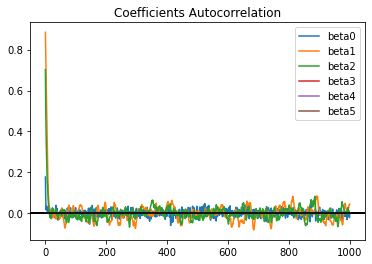

In [463]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [464]:
#Simulation 3: Informed Gibbs 2
X = np.array(df)

beta0 = beta*0.75
v0 = np.identity(6)

b0 = beta*3.7
iterations = 5000
print(X.shape)
b = informed_gibbs(X, b0, iterations, beta0, v0)

(3103, 6)
Time: 41.666178464889526 seconds


The MSE is 0.12308663501442085


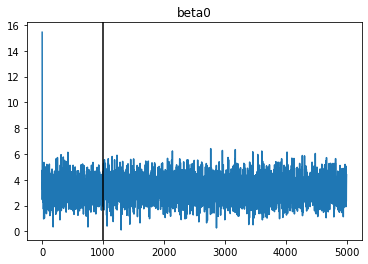

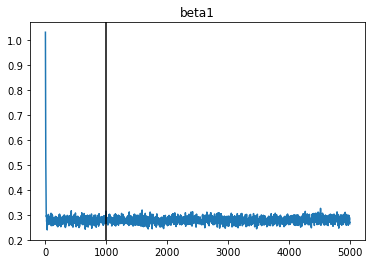

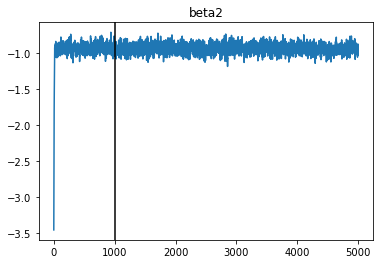

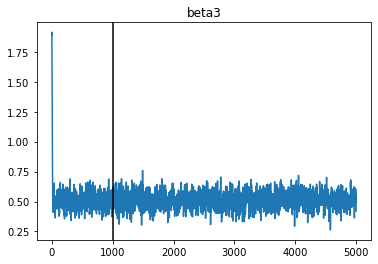

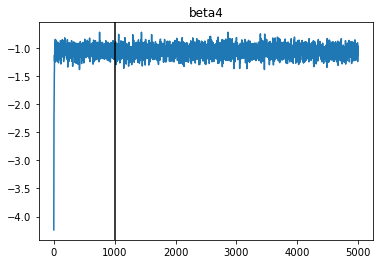

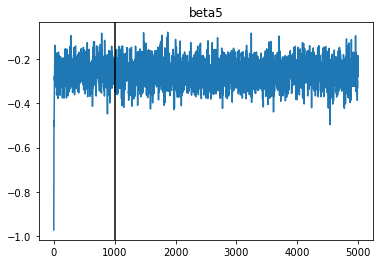

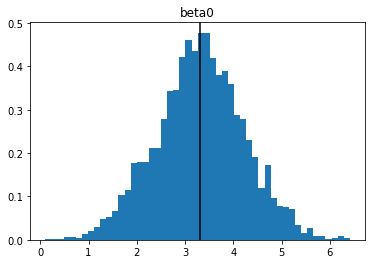

Beta0 Standard Deviation = 0.9172426976558187
Beta0 Mean = 3.3185753434033765


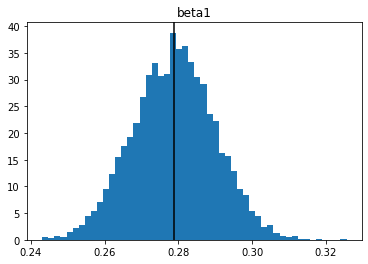

Beta1 Standard Deviation = 0.011033280206915241
Beta1 Mean = 0.2790160879833387


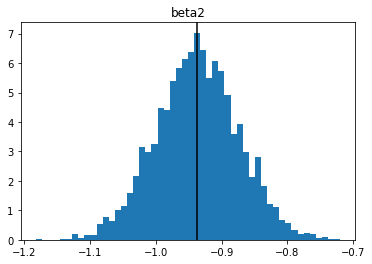

Beta2 Standard Deviation = 0.062266787834297135
Beta2 Mean = -0.9376156778293765


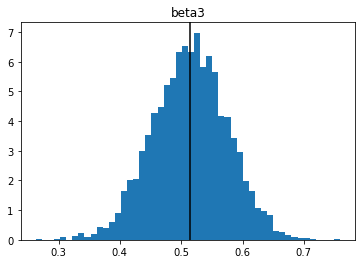

Beta3 Standard Deviation = 0.06043251969301702
Beta3 Mean = 0.5144811712081205


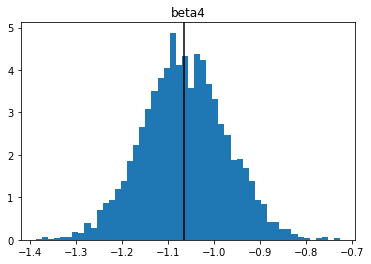

Beta4 Standard Deviation = 0.09157377986961034
Beta4 Mean = -1.0654235361486468


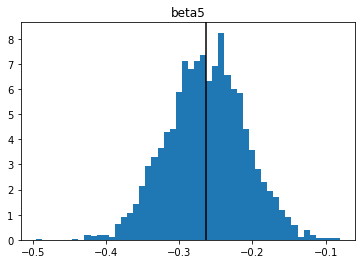

Beta5 Standard Deviation = 0.05245397059855978
Beta5 Mean = -0.2646112731151541


In [465]:
MSE = mean_squared_error(beta, np.array([b[2000:,0].mean(), b[2000:,1].mean(),b[2000:,2].mean(), b[2000:,3].mean(), b[2000:,4].mean(), b[2000:,5].mean()]))
print(f'The MSE is {MSE}')

for i in range(6):  
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(1000, color = 'k')
    plt.show()

for i in range(6):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()
    print(f'Beta{i} Standard Deviation = {b[2000:, i].std()}')
    print(f'Beta{i} Mean = {b[2000:, i].mean()}')

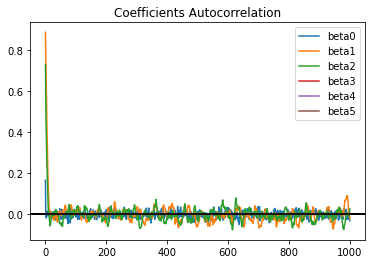

In [466]:
#Autocorrelation Analysis
corr0 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 0], b[:(4999-i), 0])
    auto_corr = auto_corr[0,1]
    corr0[i] = auto_corr

corr1 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 1], b[:(4999-i), 1])
    auto_corr = auto_corr[0,1]
    corr1[i] = auto_corr

corr2 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 2], b[:(4999-i), 2])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr3 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
corr4 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr

corr5 = np.zeros((1000,))
for i in range(1000):
    auto_corr = np.corrcoef(b[(i+1):, 3], b[:(4999-i), 3])
    auto_corr = auto_corr[0,1]
    corr2[i] = auto_corr
    
    
plt.plot(corr0, label = 'beta0')
plt.axhline(0, color = 'k')

plt.plot(corr1, label = 'beta1')
plt.axhline(0, color = 'k')

plt.plot(corr2, label = 'beta2')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta3')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta4')
plt.axhline(0, color = 'k')

plt.plot(corr3, label = 'beta5')
plt.axhline(0, color = 'k')

plt.title('Coefficients Autocorrelation')
plt.legend()
plt.show()

In [884]:
#Gibbs Sampler: Inefficient
#Generation of Data
import time
start = time.time()
X = covariates1()
beta = np.array([2,1,-1])
latent = np.dot(X, beta) + np.random.normal(size = (1000,))
Y = 1*(latent > 0)
regb = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, latent))

b0 = np.array([1.5, 0.75, -0.5])
b = np.zeros((500,3))
j = 0
while j < 500:
    b[j, :] = b0
    eta0 = np.dot(X,b0)
    z0 = np.zeros((1000,))
    for i in range(len(eta0)):
        u = random.uniform(0,1)
        if Y[i] == 0:
            p = u*ss.norm.cdf(0, loc = eta0[i])
        else:
            p = ss.norm.cdf(0, loc= eta0[i]) + u*(1 - ss.norm.cdf(0, loc = eta0[i]))
            
        q = eta0[i] + ss.norm.ppf(p)
        z0[i] = q
    mean_posterior = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, z0))
    variance_posterior = np.linalg.inv(np.dot(X.T,X))
    b1 = np.random.multivariate_normal(mean_posterior, variance_posterior)
    b0 = b1
    j += 1
    
print(b0)
end = time.time()
print(f'Time: {end - start} seconds')

[ 2.04399552  1.00177275 -1.00199492]
Time: 668.8436481952667 seconds


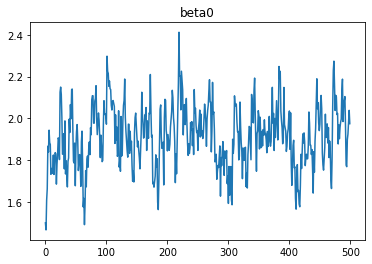

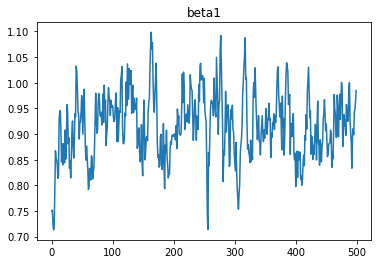

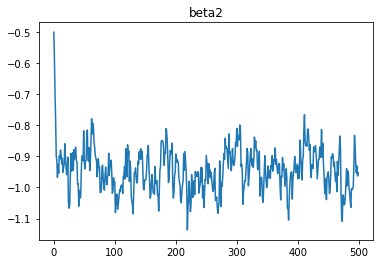

In [885]:
for i in range(3):
    plt.plot(b[:,i])
    plt.title(f'beta{i}')
    plt.axvline(100, color = 'k')
    plt.show()

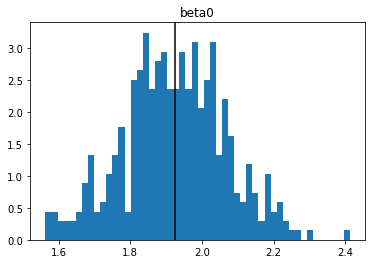

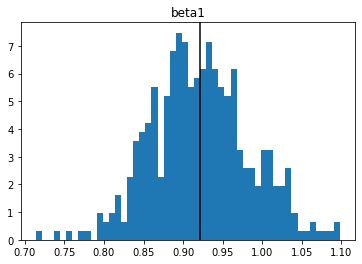

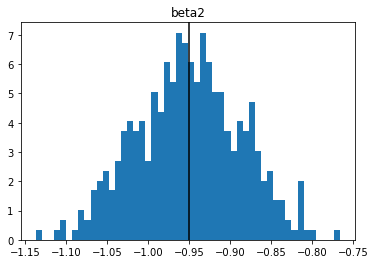

In [886]:
for i in range(3):
    plt.hist(b[1000:,i], bins = 50, density = True)
    #plt.plot(grid3, ss.norm.pdf(grid3, loc = np.mean(b[100:, 2]), scale = b[100:,2].std()), color = 'r')
    plt.axvline(np.mean(b[1000:,i]), color = 'k')
    plt.title(f'beta{i}')
    plt.show()